In [8]:
#LEITURA DO ARQUIVO CSV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import html
import re
from datetime import datetime
from io import StringIO
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython.display import clear_output
import random
from math import pi

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## IMPORTAÇÃO DOS DADOS DO PAINEL COVID - SES-MG


In [3]:
####### CASOS CONFIRMADOS

file_conf = 'xlsx_painel_18112020_confirmados.csv'
with open(file_conf, 'r', encoding='cp1251') as f:
    content = re.sub(re.compile('<.*?>'), '', html.unescape(f.read()))
df_conf = pd.read_csv(StringIO(content), sep=';')
df_conf.columns = ['MUNICIPIO','NUM_CASOS','DATA','COD_IBGE','URS','MICRO','MACRO']
df_conf.groupby(['DATA'])['NUM_CASOS'].agg('sum')

df_conf.head()

,MUNICIPIO,NUM_CASOS,DATA,COD_IBGE,URS,MICRO,MACRO
0,IPATINGA,1,04/03/2020,313130.0,CORONEL FABRICIANO,IPATINGA,VALE DO ACO
1,DIVINOPOLIS,1,07/03/2020,312230.0,DIVINOPOLIS,DIVINOPOLIS,OESTE
2,JUIZ DE FORA,1,14/03/2020,313670.0,JUIZ DE FORA,JUIZ DE FORA,SUDESTE
3,PATROCINIO,1,14/03/2020,314810.0,UBERLANDIA,PATROCINIO/MONTE CARMELO,TRIANGULO DO NORTE
4,BELO HORIZONTE,2,16/03/2020,310620.0,BELO HORIZONTE,BELO HORIZONTE/NOVA LIMA/CAETE,CENTRO


In [4]:
df_conf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119245 entries, 0 to 119244
Data columns (total 7 columns):
MUNICIPIO    119245 non-null object
NUM_CASOS    119245 non-null int64
DATA         119245 non-null object
COD_IBGE     119038 non-null float64
URS          119038 non-null object
MICRO        119038 non-null object
MACRO        119038 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 4.1+ MB


In [5]:
####### OBITOS

file_obit = 'xlsx_painel_18112020_obitos.csv'
with open(file_obit, 'r', encoding='cp1251') as f:
    content = re.sub(re.compile('<.*?>'), '', html.unescape(f.read()))
df_obit = pd.read_csv(StringIO(content), sep=';')
df_obit.columns = ['MUNICIPIO','NUM_OBITOS','DATA','COD_IBGE','URS','MICRO','MACRO']
#df_obit.groupby(['DATA'])['NUM_OBITOS'].agg('sum')

df_obit.NUM_OBITOS.sum()
#df_obit.head(10)

9605

In [6]:
df_obit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143896 entries, 0 to 143895
Data columns (total 7 columns):
MUNICIPIO     143896 non-null object
NUM_OBITOS    143896 non-null int64
DATA          143896 non-null object
COD_IBGE      143660 non-null float64
URS           143660 non-null object
MICRO         143660 non-null object
MACRO         143660 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 4.9+ MB


## Analise Diária

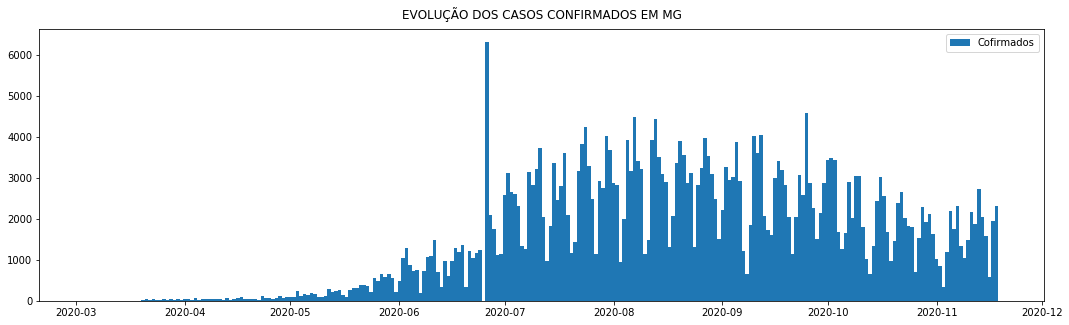

In [9]:
#Histograma Temporal - Casos Confirmados
conf_serie_dict = {}
conf_serie_dict = dict(df_conf.groupby(['DATA'])['NUM_CASOS'].agg('sum'))

conf_time_dict = {}
for k,v in conf_serie_dict.items():
    conf_time_dict[datetime.strptime(k,'%d/%m/%Y')] = v

x,y = zip(*sorted(conf_time_dict.items()))
dx = [(dt-pd.to_datetime('2020-02-01 23:50:00')).days for dt in x]
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(x,y,width=1,label='Cofirmados')
#plt.plot(dx,y,"r--")

plt.title('EVOLUÇÃO DOS CASOS CONFIRMADOS EM MG',loc='center', pad=10)
#plt.xlim([min(dx), max(dx)])
#plt.ylim([min(y), max(y)])
plt.ylim(bottom=0)
ax.legend()

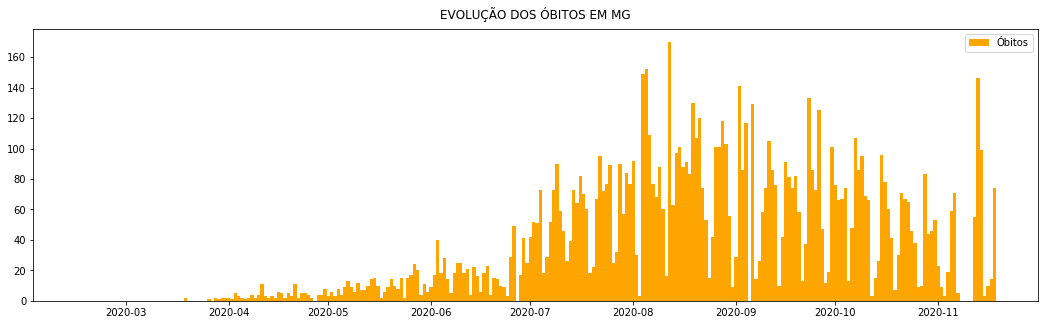

In [10]:
#Histograma Temporal - Obitos
from datetime import datetime

ob_serie_dict = {}
ob_serie_dict = dict(df_obit.groupby(['DATA'])['NUM_OBITOS'].agg('sum'))

ob_time_dict = {}
for k,v in ob_serie_dict.items():
    ob_time_dict[datetime.strptime(k,'%d/%m/%Y')] = v

x,z = zip(*sorted(ob_time_dict.items()))
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(x, z, width=1, label='Óbitos',color='orange')
plt.title('EVOLUÇÃO DOS ÓBITOS EM MG',loc='center', pad=10)
plt.xlim([pd.to_datetime('2020-02-01 23:50:00'), pd.to_datetime('2020-11-30 23:50:00')])
ax.legend()

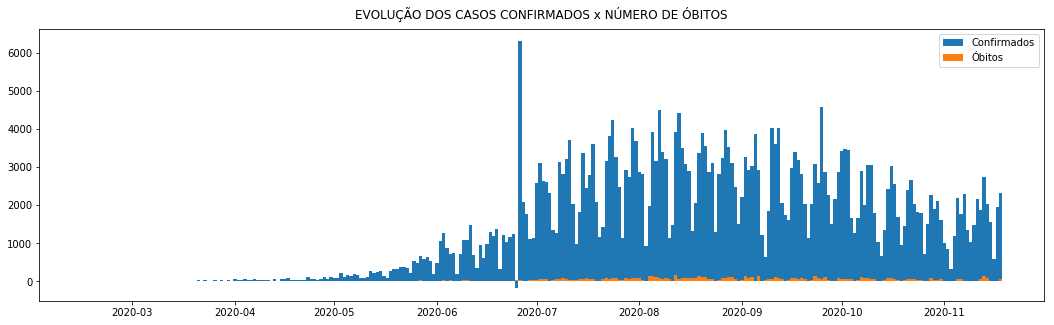

In [11]:
#Histograma Temporal - Confirmados x Obitos

c,y = zip(*sorted(conf_time_dict.items()))
o,z = zip(*sorted(ob_time_dict.items()))

f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(c,y,width=1,label='Confirmados')
plt.bar(o,z,width=1,label='Óbitos')
plt.title('EVOLUÇÃO DOS CASOS CONFIRMADOS x NÚMERO DE ÓBITOS',loc='center', pad=10)
plt.xlim([pd.to_datetime('2020-02-01 23:50:00'), pd.to_datetime('2020-11-30 23:50:00')])
ax.legend()

## Análises por Município

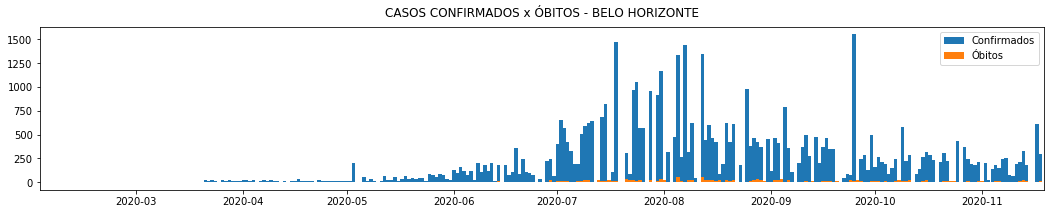

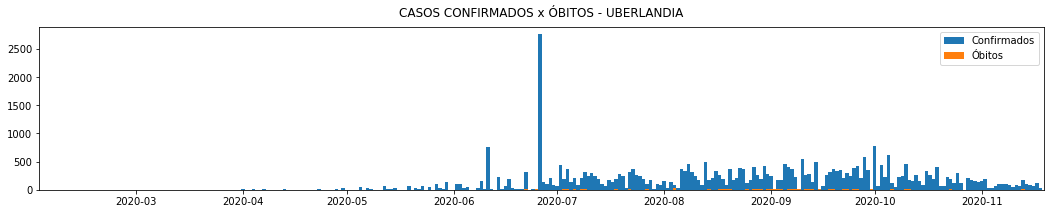

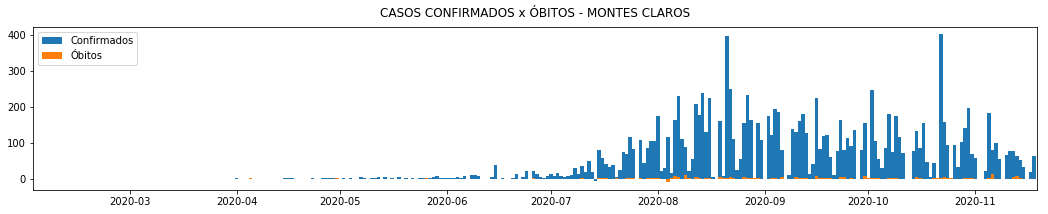

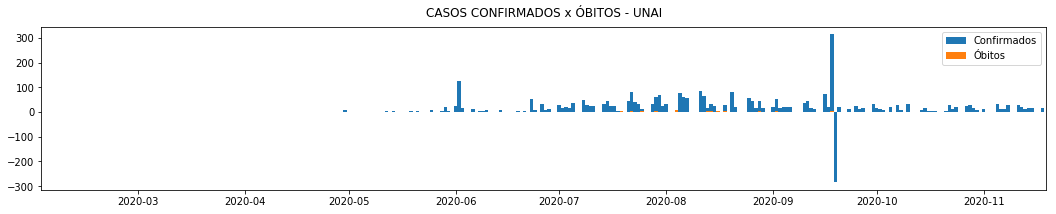

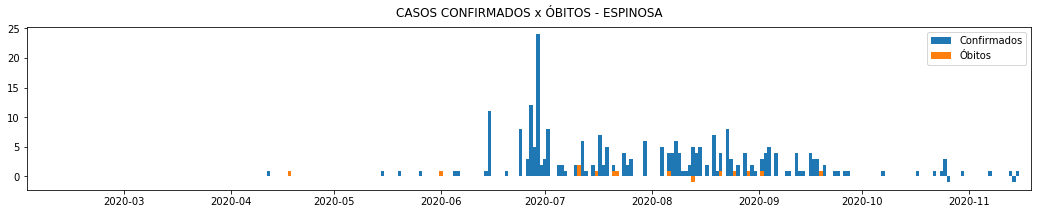

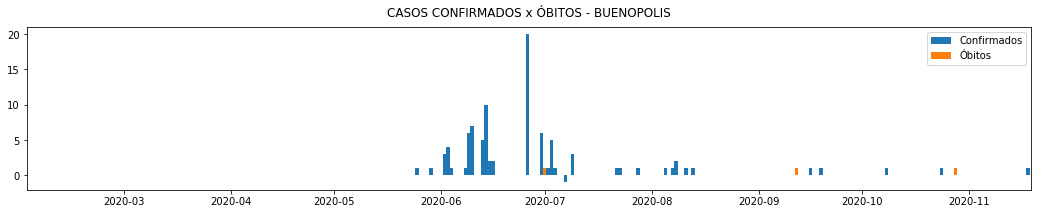

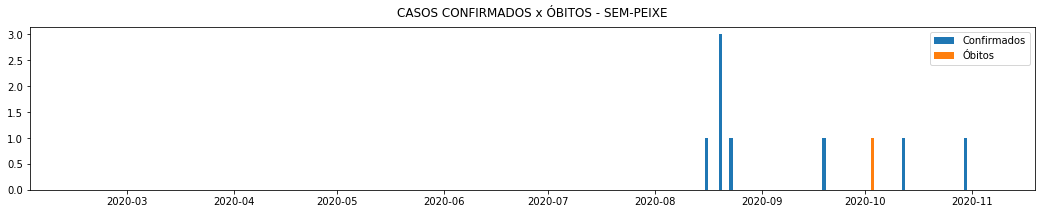

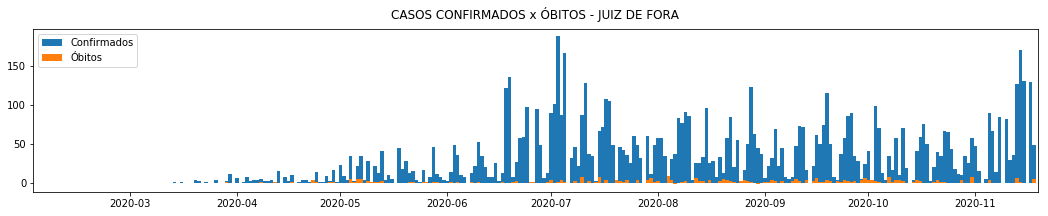

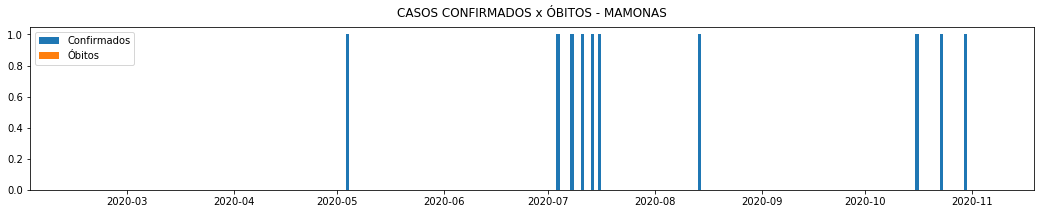

In [12]:
#PLOTANDO PADROES DE FIGURAS

df_conf_obit_cidades = {}

num_cidades = 300

cidades = ['BELO HORIZONTE','UBERLANDIA','MONTES CLAROS','UNAI','ESPINOSA','BUENOPOLIS','SEM-PEIXE','JUIZ DE FORA','MAMONAS']
#cidades = list(df_conf.MUNICIPIO.unique()[0:num_cidades])
#cidades = list(df_conf.MUNICIPIO.unique())

for cidade in cidades:
    
    if (cidade == 'OUTROS ESTADO/PAIS'): continue
    
    #CASOS CONFIRMADOS
    df_conf_cidade = df_conf[df_conf.MUNICIPIO.eq(cidade)]
    cidade_conf_serie_dict = {}
    cidade_conf_serie_dict = dict(df_conf_cidade.groupby(['DATA'])['NUM_CASOS'].agg('sum'))

    cidade_conf_time_dict = {}
    for k,v in cidade_conf_serie_dict.items():
        cidade_conf_time_dict[datetime.strptime(k,'%d/%m/%Y')] = v


    #OBITOS
    df_obit_cidade = df_obit[df_obit.MUNICIPIO.eq(cidade)]
    cidade_ob_serie_dict = {}
    cidade_ob_serie_dict = dict(df_obit_cidade.groupby(['DATA'])['NUM_OBITOS'].agg('sum'))

    cidade_ob_time_dict = {}
    for k,v in cidade_ob_serie_dict.items():
        cidade_ob_time_dict[datetime.strptime(k,'%d/%m/%Y')] = v    


    #MAIN ARRAY;
    df_conf_obit_cidades[cidade] = {'CONF':cidade_conf_time_dict,'OBIT':cidade_ob_time_dict}

    #print(len(df_conf_obit_cidades))

    #PLOT
    c,y = zip(*sorted(cidade_conf_time_dict.items()))
    o,z = zip(*sorted(cidade_ob_time_dict.items()))

    f, ax = plt.subplots(figsize=(18,3)) # set the size that you'd like (width, height)
    plt.bar(c,y,width=1,label='Confirmados')
    plt.bar(o,z,width=1,label='Óbitos')
    plt.xlim([pd.to_datetime('2020-02-01 23:50:00'), pd.to_datetime('2020-11-18 23:50:00')])
    #plt.ylim([0,1000])
    #plt.ylim(bottom=0)
    plt.title('CASOS CONFIRMADOS x ÓBITOS - ' + cidade,loc='center', pad=10)
    ax.legend()

In [13]:
#CRIANDO ARRAY PARA CLUSTERIZAÇÃO - MODO HORIZONTAL

#Timeline size
min_date = pd.to_datetime('2020-03-01 00:00:00')
max_date = pd.to_datetime('2020-11-19 00:00:00')

#Timeline Array
arr_days = np.arange((max_date - min_date).days)
#print(arr_days)

#Data Array
arr_to_df = {}
for cid, cid_row in df_conf_obit_cidades.items():
    dict_dates = {}
    for c_date, casos in cid_row['CONF'].items():
        dt = (c_date - min_date).days
        dict_dates[dt] = ({'casos':casos})
    arr_to_df[cid] = dict_dates

#Flat List
flatlist = []

#loop cidades
for f_cid, f_cid_row in arr_to_df.items():
    #loop timeline
    timeline = []
    for d in arr_days:
        
        if d in f_cid_row:
            timeline.append(f_cid_row[d]['casos'])
        else:
            timeline.append(0)
    
    flatlist.append( [f_cid] + timeline )

#print(flatlist)

#Columns DataFrame
cols = ['MUNICIPIO'] + ['D '+ str(dia) for dia in list(arr_days)]

#DataFrame
df_to_cluster = pd.DataFrame(data=flatlist, columns=cols)
df_to_cluster

,MUNICIPIO,D 0,D 1,D 2,D 3,D 4,D 5,D 6,D 7,D 8,...,D 253,D 254,D 255,D 256,D 257,D 258,D 259,D 260,D 261,D 262
0,BELO HORIZONTE,0,0,0,0,0,0,0,0,0,...,76,61,191,215,325,184,0,0,607,300
1,UBERLANDIA,0,0,0,0,0,0,0,0,0,...,86,55,81,62,170,102,77,65,121,30
2,MONTES CLAROS,0,0,0,0,0,0,0,0,0,...,0,66,76,76,64,51,34,0,20,64
3,UNAI,0,0,0,0,0,0,0,0,0,...,0,0,29,21,11,17,15,0,0,15
4,ESPINOSA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,-1,1,0,0,0
5,BUENOPOLIS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,SEM-PEIXE,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,JUIZ DE FORA,0,0,0,0,0,0,0,0,0,...,0,82,29,36,127,170,131,0,129,48
8,MAMONAS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# DEFININDO DATASET PARA O KMEANS

np_cluster = df_to_cluster.iloc[:,1:]
X = np.array(np_cluster)

X

array([[  0,   0,   0, ...,   0, 607, 300],
       [  0,   0,   0, ...,  65, 121,  30],
       [  0,   0,   0, ...,   0,  20,  64],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 129,  48],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int64)

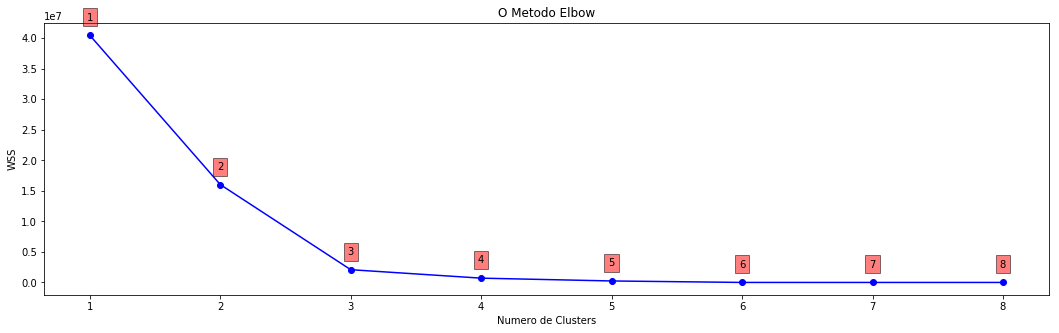

In [19]:
# METODO COTOVELO - DEFINICAO DE NUMERO DE CLUSTERS

wcss = []
limit = 9

for i in range(1, limit):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

f, ax = plt.subplots(figsize=(18,5))
plt.plot(range(1, limit), wcss, 'bo-')
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares

clear_output(wait=True)

for y in (range(1, limit)):
    plt.annotate(y, (y, wcss[y-1]),textcoords="offset points", xytext=(0,15), ha='center', bbox=dict(facecolor='red', alpha=0.5))

plt.show()

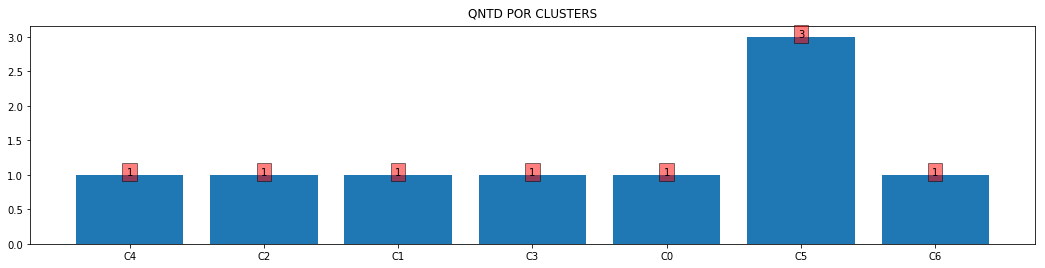

In [20]:
# CLUSTERIZACAO DE PADROES DE PROPAGAÇÃO DA PANDEMIA NOS MUNICIPIOS

n_cluster = 7

np_cluster = df_to_cluster.iloc[:,1:]
X = np.array(np_cluster)
kmeans = KMeans(n_clusters=n_cluster, init='random').fit(X)

# Labels
clst_reg = {}
clst_cid = {}
dict_clst_reg = {}
inst = list(df_to_cluster.iloc[:,0])
for idx, l in enumerate(kmeans.labels_):
    #print(l, cidades[idx])
    clst_reg.update({idx:l})
    if (l in dict_clst_reg):
        dict_clst_reg[l] += 1
        clst_cid[l].append(cidades[idx])
    else:
        dict_clst_reg[l] = 1
        clst_cid[l] = [cidades[idx]]

#for idx, vls in sorted(clst_cid.items()):
#    print('C' + str(idx), vls)

#clear_output(wait=True)
        
lab_cls = []
for k, v in dict_clst_reg.items():
    lab_cls.append('C' + str(k))

f, ax = plt.subplots(figsize=(18,4))
plt.bar(lab_cls, dict_clst_reg.values(), align='center',width=0.8)
plt.title('QNTD POR CLUSTERS',loc='center', pad=10)
for index, value in enumerate(dict_clst_reg.values()):
    plt.text(index, value, str(value), horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))    


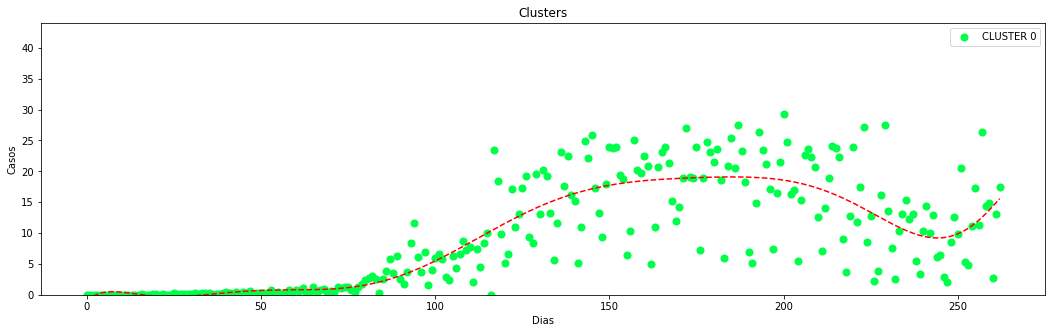

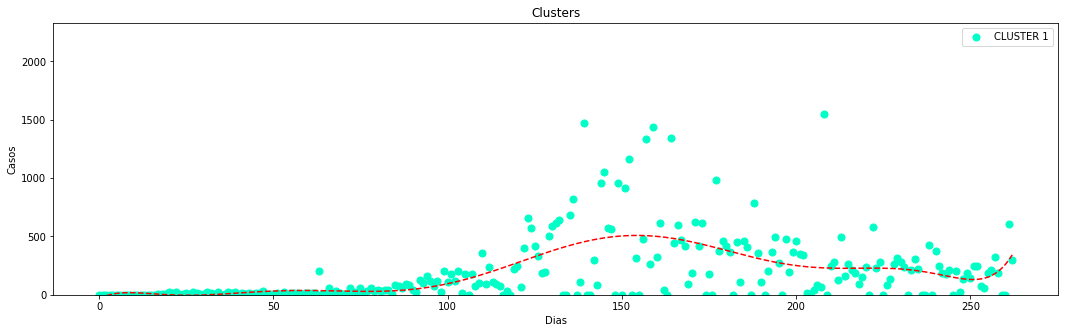

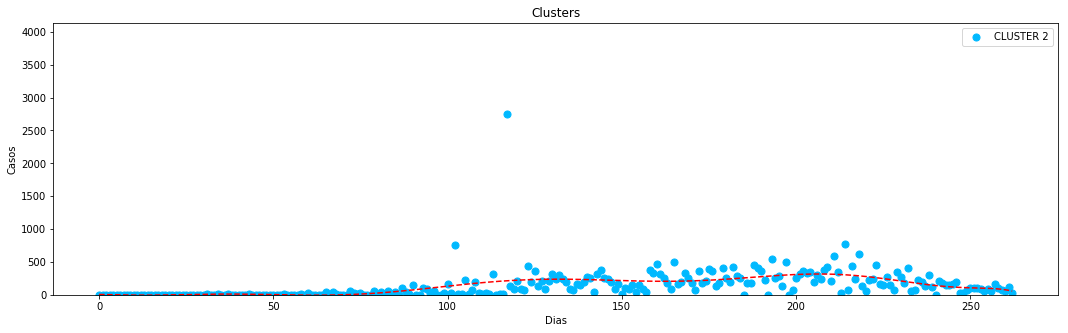

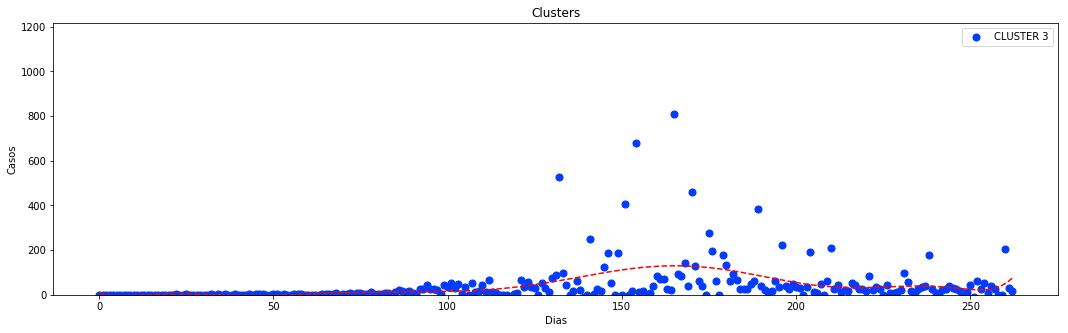

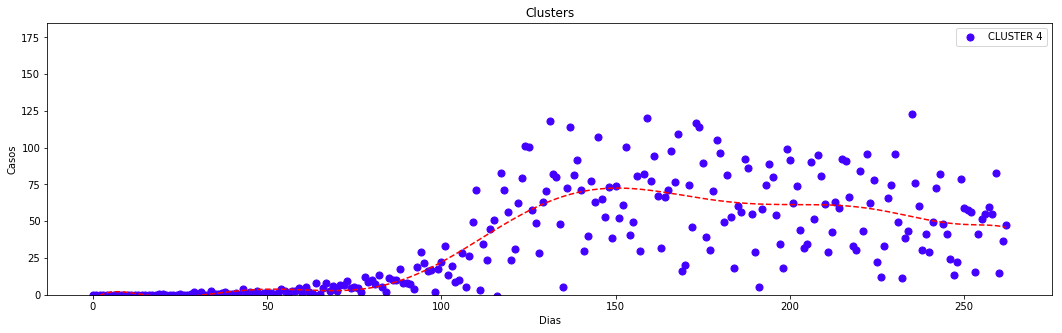

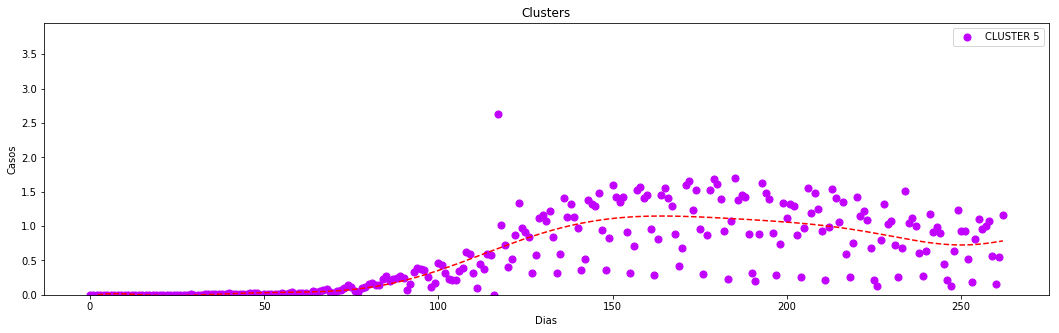

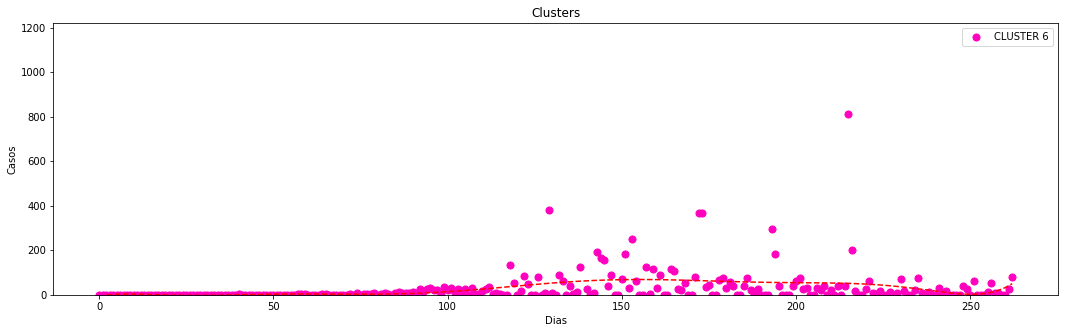

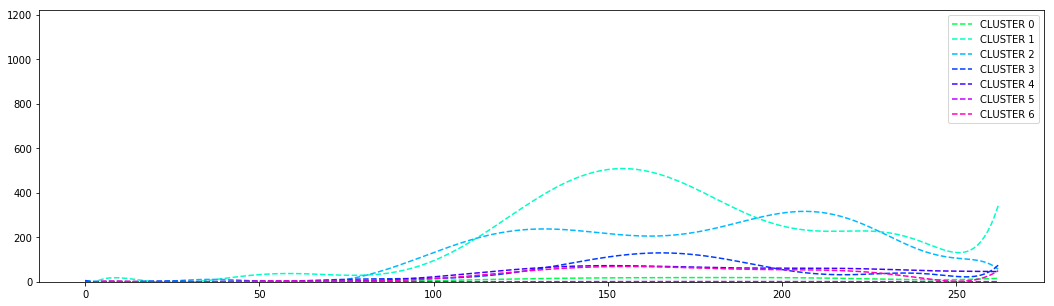

In [428]:
#SÓ CLUSTERS

clst_labels = np.sort(pd.unique(kmeans.labels_))
colors = ['r','g','b','y','m','c','k']

for p in range(0,len(kmeans.cluster_centers_)):
    
    f, ax = plt.subplots(figsize=(18,5))
        
    viridis = plt.cm.get_cmap('gist_rainbow',12)
   
    plt.scatter(Y[p], kmeans.cluster_centers_[p], s=50, color=viridis(p+5), label='CLUSTER ' + str(clst_labels[p]))
    
    plt.title('Clusters')
    plt.xlabel('Dias')
    plt.ylabel('Casos')
    plt.ylim([0, max([m.max() for m in kmeans.cluster_centers_[p]]) * 1.5])
    plt.ylim(bottom=0)
    plt.legend()
    
    #Linha de Tendencia
    z = np.polyfit(Y[p], kmeans.cluster_centers_[p], 10)
    pf = np.poly1d(z)
    plt.plot(Y[p],pf(Y[p]),"r--")

    ax.legend()
    plt.show()

#Todas as Linhas de Tendencia
f, ax = plt.subplots(figsize=(18,5))
for p in range(0,len(kmeans.cluster_centers_)):
    viridis = plt.cm.get_cmap('gist_rainbow',12)
    z = np.polyfit(Y[p], kmeans.cluster_centers_[p], 10)
    pf = np.poly1d(z)
    plt.ylim([0, max([m.max() for m in kmeans.cluster_centers_[p]]) * 1.5])
    plt.plot(Y[p],pf(Y[p]), 'r--', color= viridis(p+5), label='CLUSTER ' + str(clst_labels[p]))
    plt.legend() 

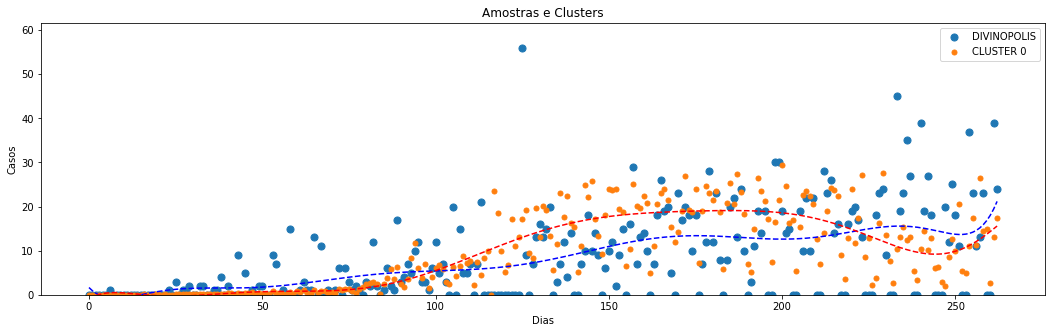

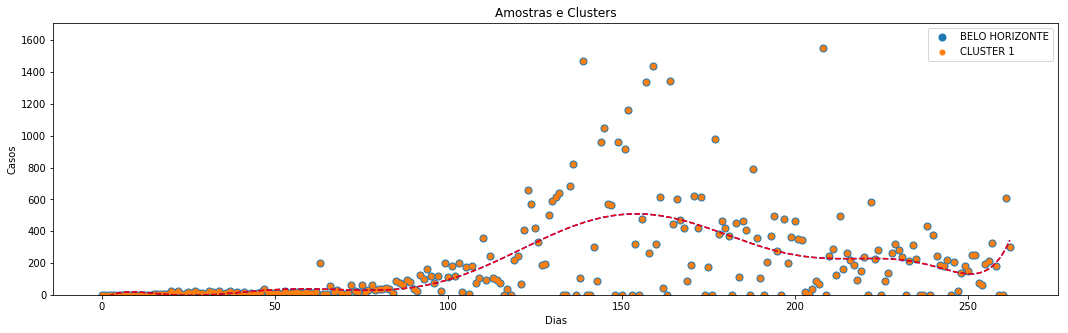

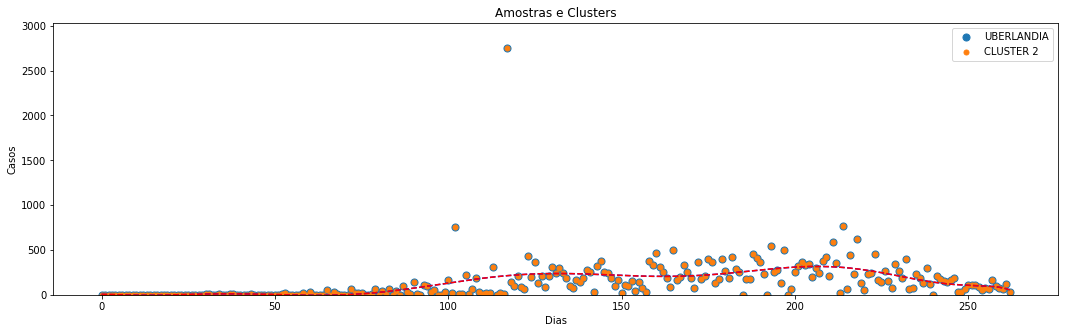

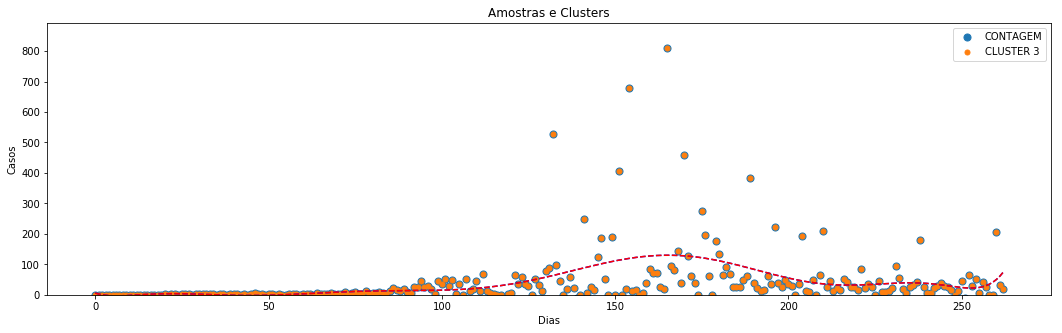

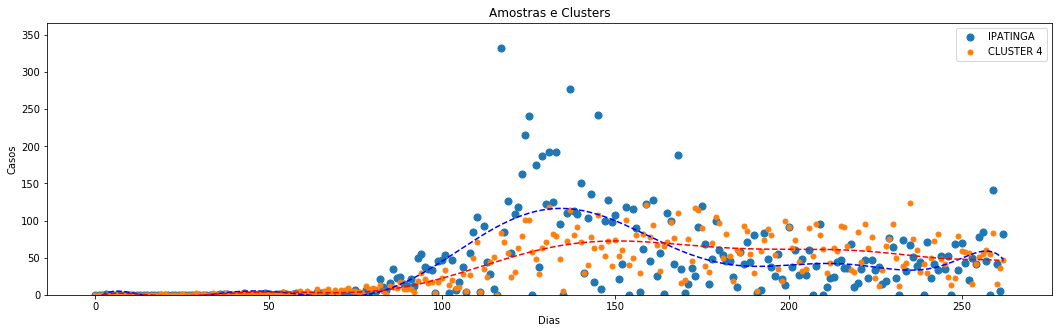

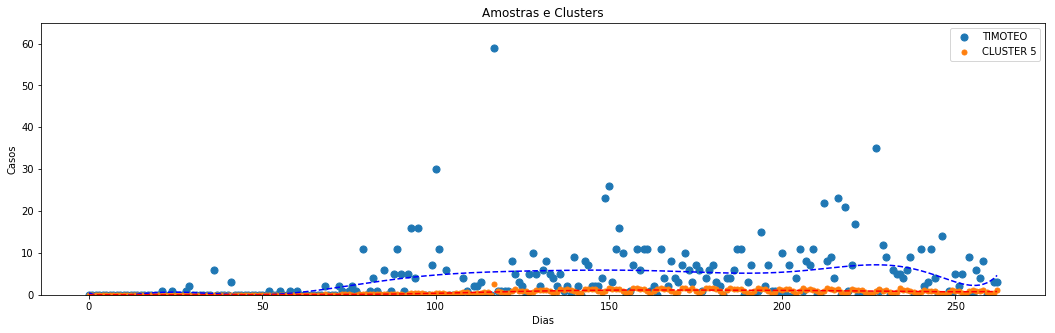

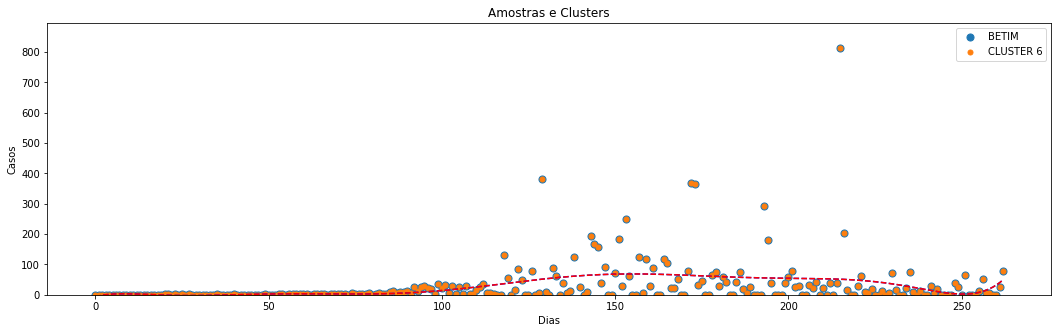

In [429]:
# PLOTANDO 1 AMOSTRA DE CADA CLUSTER

Y = []
for y in range(0,len(X)):
    Y.append(list(arr_days))

colors = ['r','g','b','y','m','c','k']

#Pick Cidade by STR

for idx, vls in sorted(clst_cid.items()):

    str_cid = vls[0]
    c_index = cidades.index(str_cid)

    f, ax = plt.subplots(figsize=(18,5))

    for p in range(0,len(X)):
        if (c_index == p):
            plt.scatter(Y[p], X[p], s=50, label=cidades[p])   
            
            #Linha de Tendencia
            z = np.polyfit(Y[p], X[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y[p],pf(Y[p]),"--b")

    for p in range(0,len(kmeans.cluster_centers_)):
        if (clst_reg[c_index] == p):
            plt.scatter(Y[p], kmeans.cluster_centers_[p], s=25, label='CLUSTER ' + str(kmeans.labels_[c_index]))
            
            #Linha de Tendencia
            z = np.polyfit(Y[p], kmeans.cluster_centers_[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y[p],pf(Y[p]),"r--")

    plt.title('Amostras e Clusters')
    plt.xlabel('Dias')
    plt.ylabel('Casos')
    #plt.ylim([0, 2000])
    plt.ylim([0, max([m.max() for m in X[c_index]]) * 1.1])
    plt.ylim(bottom=0)
    #plt.legend()

    ax.legend()
    plt.show()

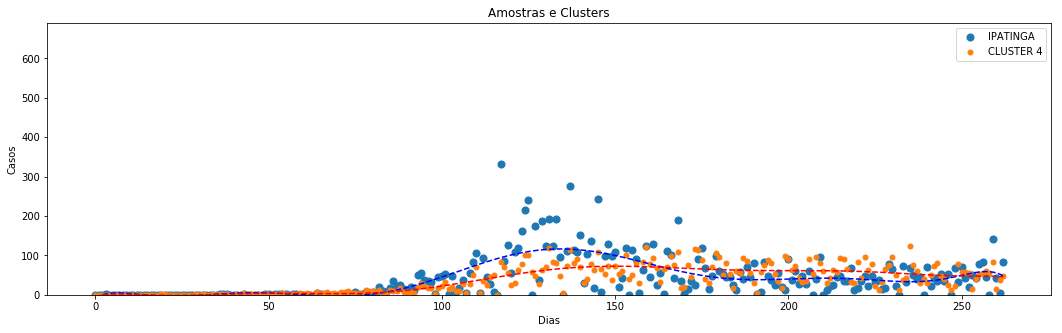

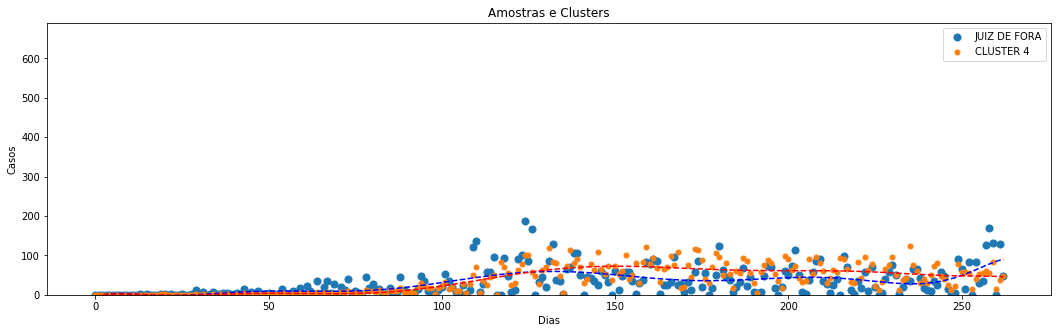

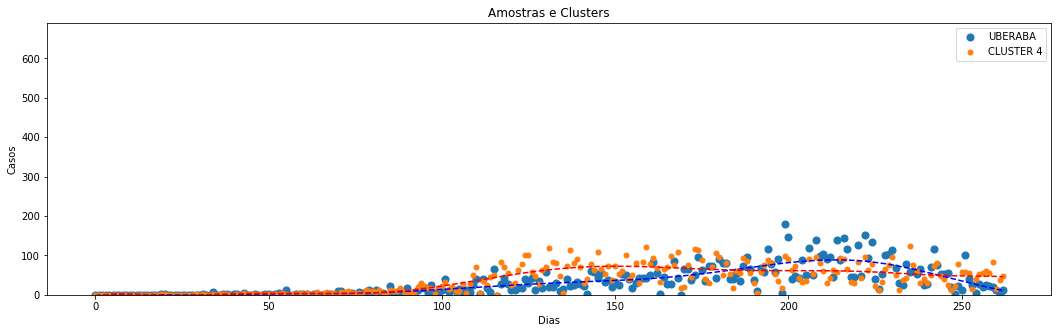

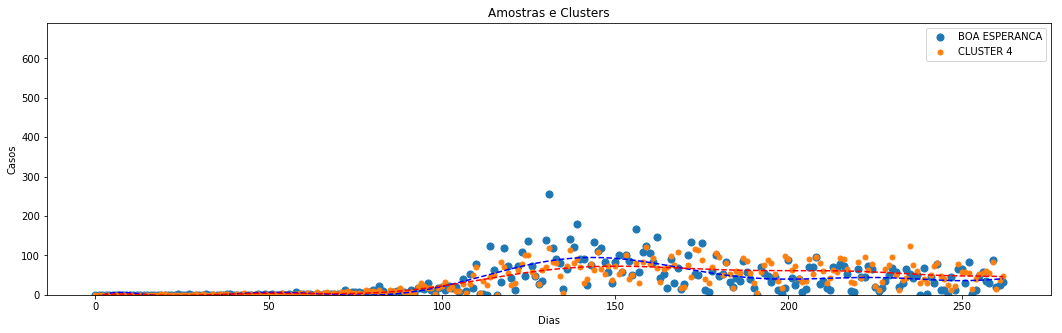

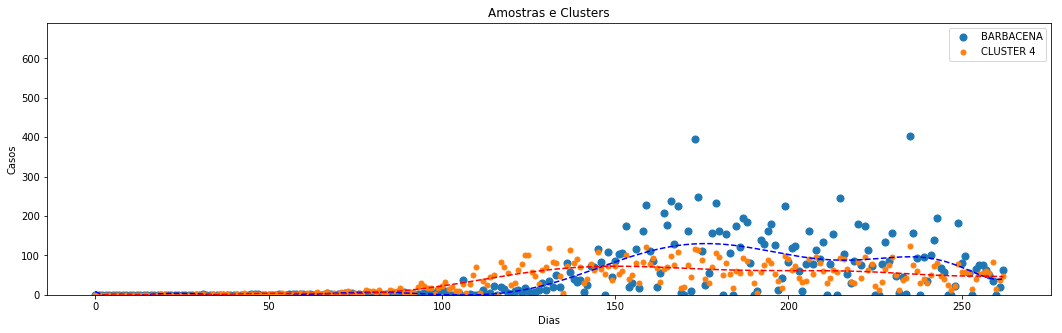

In [433]:
# PLOTANDO TODAS AS AMOSTRAS DE UM CLUSTER

Y = []
for y in range(0,len(X)):
    Y.append(list(arr_days))

colors = ['r','g','b','y','m','c','k']

cluster = 4

for str_cid in clst_cid[cluster]:

    c_index = cidades.index(str_cid)
    #print(c_index, str_cid)
    
    f, ax = plt.subplots(figsize=(18,5))

    #AMOSTRA
    for p in range(0,len(X)):
        if (c_index == p):
            plt.scatter(Y[p], X[p], s=50, label=cidades[p])   
            
            #Linha de Tendencia
            z = np.polyfit(Y[p], X[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y[p],pf(Y[p]),"--b")

    #CLUSTER
    for p in range(0,len(kmeans.cluster_centers_)):
        if (clst_reg[c_index] == p):
            plt.scatter(Y[p], kmeans.cluster_centers_[p], s=25, label='CLUSTER ' + str(kmeans.labels_[c_index]))
    
            #Linha de Tendencia
            z = np.polyfit(Y[p], kmeans.cluster_centers_[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y[p],pf(Y[p]),"r--")
            
    plt.title('Amostras e Clusters')
    plt.xlabel('Dias')
    plt.ylabel('Casos')
    plt.ylim([0, max([m.max() for m in X[p]]) * 1.5])
    plt.ylim(bottom=0)
    #plt.legend()

    ax.legend()
    plt.show()

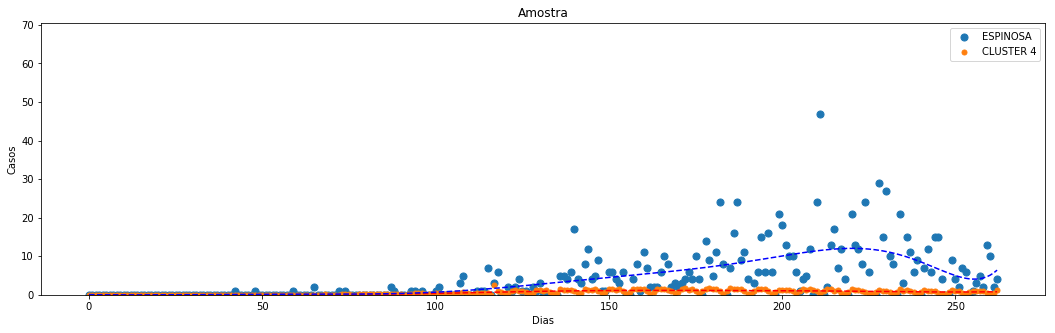

In [465]:
#SÓ CIDADES

#Timeline Axis
Y = []
for y in range(0,len(X)):
    Y.append(list(arr_days))

for p in range(0,len(X)):
    if cidades[p] == 'ESPINOSA':
        f, ax = plt.subplots(figsize=(18,5))
        plt.scatter(Y[p], X[p], s=50, label=cidades[p])
        plt.scatter(Y[p], kmeans.cluster_centers_[kmeans.labels_[p]], s=25, label='CLUSTER ' + str(kmeans.labels_[c_index]))
        plt.title('Amostra')
        plt.xlabel('Dias')
        plt.ylabel('Casos')
        #plt.ylim([0,1000])
        plt.ylim([0, max([m.max() for m in X[p]]) * 1.5])
        plt.ylim(bottom=0)
        plt.legend()

        #Linha de Tendencia
        z = np.polyfit(Y[p], kmeans.cluster_centers_[kmeans.labels_[p]], 10)
        pf = np.poly1d(z)
        plt.plot(Y[p],pf(Y[p]),"r--")

         #Linha de Tendencia
        z = np.polyfit(Y[p], X[p], 10)
        pf = np.poly1d(z)
        plt.plot(Y[p],pf(Y[p]),"--b")

        ax.legend()
        plt.show()

## Analise Semanal

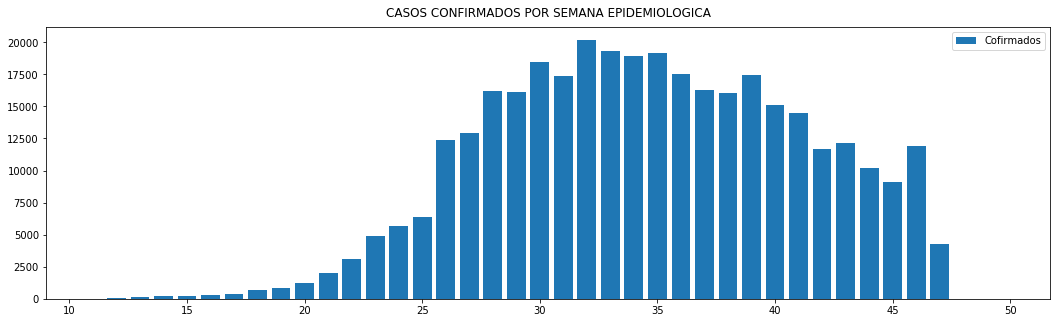

In [6]:
#Histograma Temporal - Casos Confirmados
conf_sem_dict = {}
conf_sem_dict = dict(df_conf.groupby(['DATA'])['NUM_CASOS'].agg('sum'))

conf_sem_time_dict = {}
for k,v in conf_sem_dict.items():
    data_datetime = datetime.strptime(k,'%d/%m/%Y')
    n_week = data_datetime.isocalendar()[1]
    if n_week in conf_sem_time_dict:
        conf_sem_time_dict[n_week] += v 
    else:
        conf_sem_time_dict[n_week] = 0

x,y = zip(*sorted(conf_sem_time_dict.items()))
f, ax = plt.subplots(figsize=(18,5))
plt.bar(x,y,width=0.8,label='Cofirmados')
plt.title('CASOS CONFIRMADOS POR SEMANA EPIDEMIOLOGICA',loc='center', pad=10)
plt.xlim( min([sem for sem, casos in conf_sem_time_dict.items()]) * 0.9, max([sem for sem, casos in conf_sem_time_dict.items()]) * 1.1 )
#plt.ylim(0, 20000)
ax.legend()

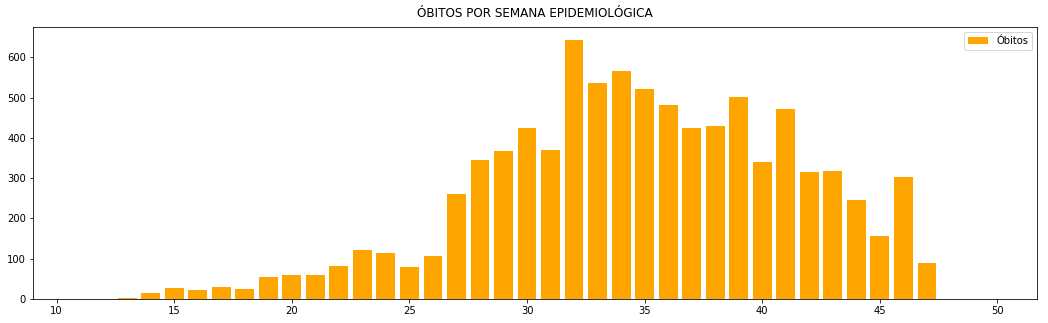

In [7]:
#Histograma Temporal - Obitos

ob_sem_dict = {}
ob_sem_dict = dict(df_obit.groupby(['DATA'])['NUM_OBITOS'].agg('sum'))

ob_sem_time_dict = {}
for k,v in ob_sem_dict.items():
    data_datetime = datetime.strptime(k,'%d/%m/%Y')
    n_week = data_datetime.isocalendar()[1]
    if n_week in ob_sem_time_dict:
        ob_sem_time_dict[n_week] += v 
    else:
        ob_sem_time_dict[n_week] = 0

x,z = zip(*sorted(ob_sem_time_dict.items()))
f, ax = plt.subplots(figsize=(18,5)) # set the size that you'd like (width, height)
plt.bar(x, z, width=0.8, label='Óbitos',color='orange')
plt.title('ÓBITOS POR SEMANA EPIDEMIOLÓGICA',loc='center', pad=10)
plt.xlim( min([sem for sem, casos in conf_sem_time_dict.items()]) * 0.9, max([sem for sem, casos in conf_sem_time_dict.items()]) * 1.1 )
ax.legend()

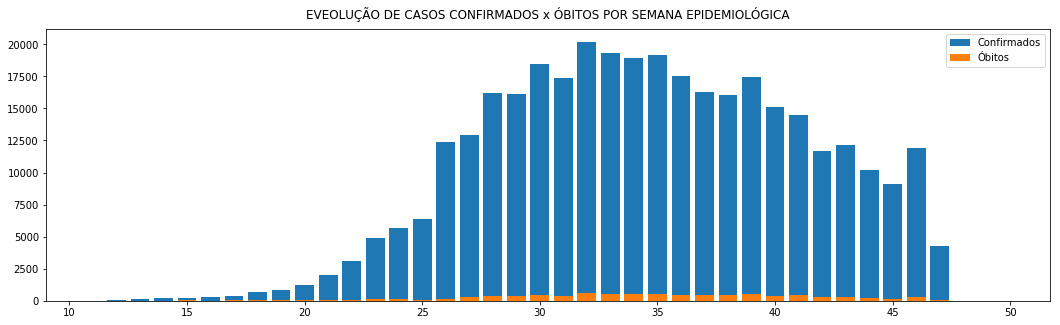

In [8]:
c,y = zip(*sorted(conf_sem_time_dict.items()))
o,z = zip(*sorted(ob_sem_time_dict.items()))

f, ax = plt.subplots(figsize=(18,5))
plt.bar(c,y,width=0.8,label='Confirmados')
plt.bar(o,z,width=0.8,label='Óbitos')
plt.title('EVEOLUÇÃO DE CASOS CONFIRMADOS x ÓBITOS POR SEMANA EPIDEMIOLÓGICA',loc='center', pad=10)
plt.xlim( min([sem for sem, casos in conf_sem_time_dict.items()]) * 0.9, max([sem for sem, casos in conf_sem_time_dict.items()]) * 1.1 )
ax.legend()

In [9]:
#PLOTANDO PADROES DE FIGURAS POR CIDADES

df_sem_conf_obit_cidades = {}
num_cidades = 300

cidades=[]
df_conf_obit_cidades = {}
#cidades = ['BELO HORIZONTE','UBERLANDIA','MONTES CLAROS','UNAI','ESPINOSA','BUENOPOLIS','SEM-PEIXE','JUIZ DE FORA','MAMONAS']
#cidades = list(df_conf.MUNICIPIO.unique()[0:num_cidades])
cidades = list(df_conf.MUNICIPIO.unique())

for cidade in cidades:
    
    if (cidade == 'OUTROS ESTADO/PAIS'): continue
    
    #CASOS CONFIRMADOS
    df_sem_conf_cidade = df_conf[df_conf.MUNICIPIO.eq(cidade)]
    conf_serie_dict = {}
    conf_serie_dict = dict(df_sem_conf_cidade.groupby(['DATA'])['NUM_CASOS'].agg('sum'))
    
    conf_sem_dict = {}
    for k,v in conf_serie_dict.items():
        data_datetime = datetime.strptime(k,'%d/%m/%Y')
        n_week = data_datetime.isocalendar()[1]
        if n_week in conf_sem_dict:
            conf_sem_dict[n_week] += v 
        else:
            conf_sem_dict[n_week] = 0
            
    #OBITOS
    df_sem_ob_cidade = df_obit[df_obit.MUNICIPIO.eq(cidade)]
    ob_serie_dict = {}
    ob_serie_dict = dict(df_sem_ob_cidade.groupby(['DATA'])['NUM_OBITOS'].agg('sum'))
    
    ob_sem_dict = {}
    for k,v in ob_serie_dict.items():
        data_datetime = datetime.strptime(k,'%d/%m/%Y')
        n_week = data_datetime.isocalendar()[1]
        if n_week in ob_sem_dict:
            ob_sem_dict[n_week] += v 
        else:
            ob_sem_dict[n_week] = 0


    #MAIN ARRAY;
    df_sem_conf_obit_cidades[cidade] = {'CONF':conf_sem_dict,'OBIT':ob_sem_dict}
    print(len(df_sem_conf_obit_cidades), cidade)
    print("".join(list(np.full((int(len(df_sem_conf_obit_cidades)/len(cidades)*100)),'|'))))
    #print(df_sem_conf_obit_cidades[cidade])
    clear_output(wait=True)
    
    
   
    #PLOT
    if (0):
        c, y, o, z = None, None, None, None
        c,y = zip(*sorted(conf_sem_dict.items()))
        o,z = zip(*sorted(ob_sem_dict.items()))

        f, ax = plt.subplots(figsize=(18,3))
        plt.bar(c,y,width=0.8,label='Confirmados')
        plt.bar(o,z,width=0.8,label='Óbitos')
        plt.xlim(0,50)
        #plt.ylim([0,5000])
        #plt.ylim(bottom=0)
        plt.title('CASOS CONFIRMADOS x ÓBITOS POR SEMANA EPIDEMIOLOGICA - ' + cidade,loc='center', pad=10)
        ax.legend()

854 VIRGINIA
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [10]:
#CRIANDO ARRAY PARA CLUSTERIZAÇÃO - MODO HORIZONTAL SEMANAL

#Timeline size
min_sem = min([sem for sem, casos in conf_sem_time_dict.items()])
max_sem = max([sem for sem, casos in conf_sem_time_dict.items()])

#Timeline Array
arr_sem = np.arange(min_sem, max_sem + 1)

#Semana de Casos Array
arr_sem_to_df = {}
for cid, cid_row in df_sem_conf_obit_cidades.items():
    dict_sem = {}
    for n_sem, n_casos in cid_row['CONF'].items():
        dict_sem[n_sem] = ({'casos': n_casos})
    arr_sem_to_df[cid] = dict_sem

#Flat List
flatlist = []

#loop cidades
for f_s_cid, f_s_cid_row in arr_sem_to_df.items():
    #loop timeline
    timeline = []
    for s in arr_sem:
        
        if s in f_s_cid_row:
            timeline.append(f_s_cid_row[s]['casos'])
        else:
            timeline.append(0)
    
    flatlist.append( [f_s_cid] + timeline )

#print(flatlist)

#Columns DataFrame
cols = ['MUNICIPIO'] + ['S'+ str(sem) for sem in list(arr_sem)]

#DataFrame
df_sem_to_cluster = pd.DataFrame(data=flatlist, columns=cols)
df_sem_to_cluster.head(10)

,MUNICIPIO,S10,S11,S12,S13,S14,S15,S16,S17,S18,...,S38,S39,S40,S41,S42,S43,S44,S45,S46,S47
0,IPATINGA,0,0,0,0,0,2,2,5,2,...,250,223,176,178,235,307,221,234,391,87
1,DIVINOPOLIS,0,0,0,5,4,7,8,17,19,...,108,83,81,85,74,149,103,86,107,63
2,JUIZ DE FORA,0,0,5,5,21,17,20,21,41,...,371,308,226,190,229,268,155,259,575,177
3,PATROCINIO,0,0,0,0,2,1,1,0,0,...,148,125,120,79,110,69,29,15,66,3
4,BELO HORIZONTE,0,0,52,78,76,83,89,81,273,...,1734,1994,1567,1482,1323,1179,1202,990,976,907
5,CORONEL FABRICIANO,0,0,0,0,0,0,3,0,0,...,95,112,85,111,74,86,108,86,244,62
6,NOVA LIMA,0,0,6,11,13,6,0,2,6,...,82,135,167,216,460,17,132,93,145,158
7,SETE LAGOAS,0,0,0,0,0,0,2,0,0,...,213,229,109,131,84,106,51,82,105,79
8,UBERLANDIA,0,0,2,5,18,10,10,24,44,...,1327,1748,1706,1279,1296,985,795,461,547,151
9,MARIANA,0,0,0,0,0,0,3,5,1,...,43,75,45,58,41,56,47,3,59,0


1 198126108.53395787
2 63241070.02816903
3 41724099.91310228 3  Silhouette Score: 0.9389326553794982
4 21932471.807142854 4  Silhouette Score: 0.9233413259699721
5 14268747.398742812 5  Silhouette Score: 0.8356736144179523
6 11365170.487600727 6  Silhouette Score: 0.8335256467273396
7 9752713.987600725 7  Silhouette Score: 0.8334634288202802
8 8302230.017790427 8  Silhouette Score: 0.8364347322611453
9 6983091.606382449 9  Silhouette Score: 0.7328904810579896
10 6122441.566571001 10  Silhouette Score: 0.6874087131252701
11 5635192.333517388 11  Silhouette Score: 0.6858340383221025
12 5043160.868135538 12  Silhouette Score: 0.6155898991450052
13 4554709.8855416635 13  Silhouette Score: 0.6248892486882156
14 4179818.543850236 14  Silhouette Score: 0.6245641427227255
15 3788675.279785331 15  Silhouette Score: 0.5958559567829609
16 3572248.8740650513 16  Silhouette Score: 0.6349523784494873
17 3293681.359626895 17  Silhouette Score: 0.6210997245519664
18 3080140.044406401 18  Silhouette Sc

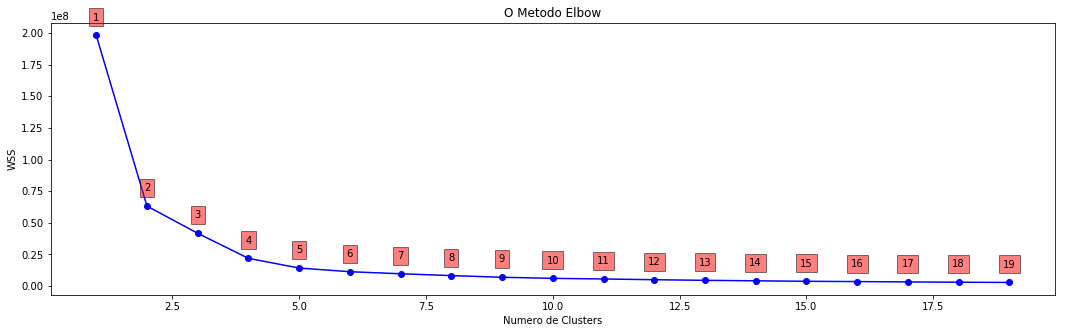

In [13]:
# METODO COTOVELO - DEFINICAO DE NUMERO DE CLUSTERS

from sklearn.cluster import KMeans
from IPython.display import clear_output

# DATA
np_cluster_semanal = df_sem_to_cluster.iloc[:,1:].astype(float)

# NORMALIZE
#scaler = StandardScaler()
#np_cluster_semanal = scaler.fit_transform(np_cluster_semanal)

X_semanal = np.array(np_cluster_semanal)

wcss = []
limit = 20

for i in range(1, limit):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X_semanal)
    
    #metrics
    if (i > 2):
        cluster_labels = kmeans.fit_predict(X_semanal)
        silhouette_avg = silhouette_score(X_semanal, cluster_labels)
        print (i,kmeans.inertia_, i, " Silhouette Score: " + str(silhouette_avg))
    else:
        print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

    
print(kmeans)
f, ax = plt.subplots(figsize=(18,5))
plt.plot(range(1, limit), wcss, 'bo-')
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares

#clear_output(wait=True)

for y in (range(1, limit)):
    plt.annotate(y, (y, wcss[y-1]),textcoords="offset points", xytext=(0,15), ha='center', bbox=dict(facecolor='red', alpha=0.5))

plt.show()

In [14]:
X_semanal

array([[  0.,   0.,   0., ..., 234., 391.,  87.],
       [  0.,   0.,   0., ...,  86., 107.,  63.],
       [  0.,   0.,   5., ..., 259., 575., 177.],
       ...,
       [  0.,   0.,   0., ...,   5.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   1.,   2.,   0.]])

## Clustering

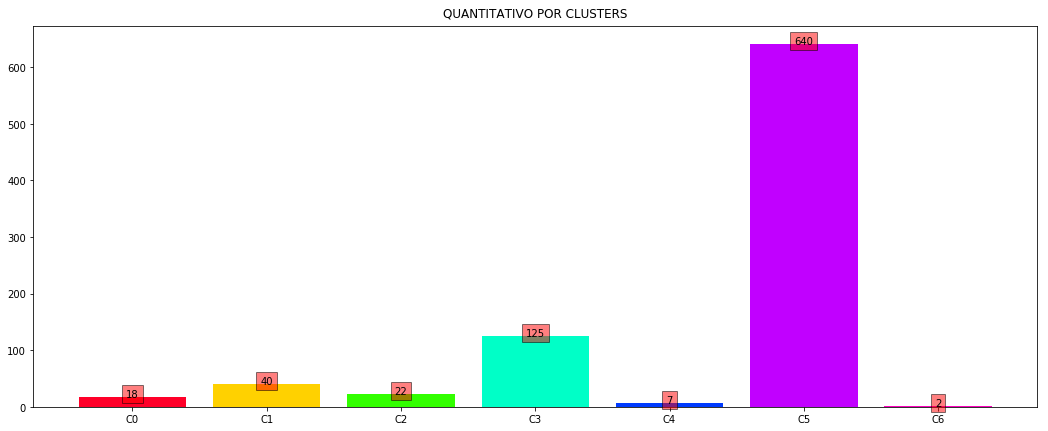

In [16]:
# CLUSTERIZACAO DE PADROES DE PROPAGAÇÃO DA PANDEMIA NOS MUNICIPIOS - METODO SEMANAL

n_cluster = 7

# DATA
np_cluster_semanal = df_sem_to_cluster.iloc[:,1:].astype(float)

# NORMALIZE
#scaler = StandardScaler()
#np_cluster_semanal = scaler.fit_transform(np_cluster_semanal)

# CLUSTERIZE
X_semanal = np.array(np_cluster_semanal)
kmeans = KMeans(n_clusters=n_cluster, init='random').fit(X_semanal)

# REPRODUZINDO RESULTADO IGUAL AO TRABALHO
#labels
#print(kmeans.labels_)
kmeans.labels_2 = list(range(0, 854))
for idx, l in enumerate(kmeans.labels_):
    if (list(kmeans.labels_).count(l) == 2):
        kmeans.labels_2[idx] = 6
    if (list(kmeans.labels_).count(l)) == 640:
        kmeans.labels_2[idx] = 5
    if (list(kmeans.labels_).count(l)) == 7:
        kmeans.labels_2[idx] = 4
    if (list(kmeans.labels_).count(l)) == 125:
        kmeans.labels_2[idx] = 3
    if (list(kmeans.labels_).count(l)) == 22:
        kmeans.labels_2[idx] = 2
    if (list(kmeans.labels_).count(l)) == 40:
        kmeans.labels_2[idx] = 1
    if (list(kmeans.labels_).count(l)) == 18:
        kmeans.labels_2[idx] = 0
        
kmeans.labels_ = kmeans.labels_2

# Labels
clst_sem_reg = {}
clst_sem_cid = {}
dict_clst_sem_reg = {}
inst = list(df_sem_to_cluster.iloc[:,0])
for idx, l in enumerate(kmeans.labels_):
    #print(l, cidades[idx])
    clst_sem_reg.update({idx:l})
    if (l in dict_clst_sem_reg):
        dict_clst_sem_reg[l] += 1
        clst_sem_cid[l].append(cidades[idx])
    else:
        dict_clst_sem_reg[l] = 1
        clst_sem_cid[l] = [cidades[idx]]

#print(dict(sorted(clst_sem_cid.items())))
#print(clst_reg.values()) 
#clear_output(wait=True)

# Sorting 
dict_clst_sem_reg = dict(sorted(dict_clst_sem_reg.items()))


lab_cls = []
for k, v in dict_clst_sem_reg.items():
    lab_cls.append('C' + str(k))

viridis = plt.cm.get_cmap('gist_rainbow', 12)    
    
f, ax = plt.subplots(figsize=(18,7))
plt.bar(lab_cls, dict_clst_sem_reg.values(), align='center',width=0.8, color=viridis([i+i for i in list(dict_clst_sem_reg.keys())]))
plt.title('QUANTITATIVO POR CLUSTERS',loc='center', pad=10)
for index, value in enumerate(dict_clst_sem_reg.values()):
    plt.text(index, value, str(value), horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))    

## Kmeans Silhouette

In [25]:
# REPRODUZINDO CENTROIDS RESULTADO IGUAL AO TRABALHO

#print(kmeans.cluster_centers_)

#temp
temp_list = [[],[],[],[],[],[],[]]

temp_list[0] = kmeans.cluster_centers_[0]
temp_list[1] = kmeans.cluster_centers_[5]
temp_list[2] = kmeans.cluster_centers_[4]
temp_list[3] = kmeans.cluster_centers_[3]
temp_list[4] = kmeans.cluster_centers_[6]
temp_list[5] = kmeans.cluster_centers_[2]
temp_list[6] = kmeans.cluster_centers_[1]

#print(temp_list[1])
#print(kmeans.cluster_centers_[1])
kmeans.cluster_centers_ = np.array(temp_list)

#kmeans.cluster_centers_ = kmeans.cluster_centers_2    

For n_clusters = 7 The average silhouette_score is : 0.5133391589006464
For Cluster = 0 The average silhouette_score is : -0.05869177755357967
For Cluster = 1 The average silhouette_score is : -0.03521010361469898
For Cluster = 2 The average silhouette_score is : 0.0991708893364973
For Cluster = 3 The average silhouette_score is : -0.009606212290840879
For Cluster = 4 The average silhouette_score is : -0.0032711130470014543
For Cluster = 5 The average silhouette_score is : 0.6871376631113381
For Cluster = 6 The average silhouette_score is : 0.06515410636459201


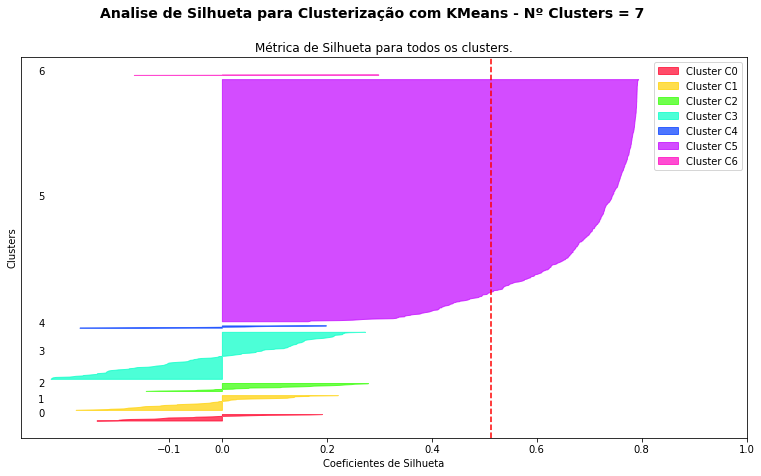

In [48]:
import matplotlib.cm as cm

Y_sem = []
for y in range(0,len(X_semanal)):
    Y_sem.append(list(arr_sem))

range_n_clusters = [7]
for n_clusters in range_n_clusters:
    
    fig, ax1 = plt.subplots(figsize=(13,7))

    # Initialize the clusterer with n_clusters value and a random generator
    clusteres = KMeans(n_clusters=n_clusters, init='random')
    cluster_labels = clusteres.fit_predict(X_semanal)
    cluster_labels = np.array(kmeans.labels_)
    #print(cluster_labels)
    #print(np.array(kmeans.labels_))
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X_semanal, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_semanal, cluster_labels)
    #print(sample_silhouette_values)
    
    silhouette_avg_c = []
    viridis = plt.cm.get_cmap('gist_rainbow', 12)    
   
    y_lower = 10
    for i in range(n_clusters):

        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        #Average by Cluster
        silhouette_avg_c.append(sample_silhouette_values[cluster_labels == i].mean())
   
        #Limits
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        #Plotting
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=viridis(i+i), edgecolor=viridis(i+i), alpha=0.7 , label="Cluster C" + str(i))

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.35, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    
    ax1.set_title("Métrica de Silhueta para todos os clusters.")
    ax1.set_xlabel("Coeficientes de Silhueta")
    ax1.set_ylabel("Clusters")

    # The vertical line for average silhouette score of each cluster
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    
    # The vertical line for average silhouette score of all the values
    viridis = plt.cm.get_cmap('gist_rainbow', 12)    
    for i, vlr in enumerate(silhouette_avg_c):
        print("For Cluster =", i, "The average silhouette_score is :", vlr)
        #ax1.axvline(x=vlr, color=viridis(i+i), linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Analise de Silhueta para Clusterização com KMeans - Nº Clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
ax1.legend()
plt.show()

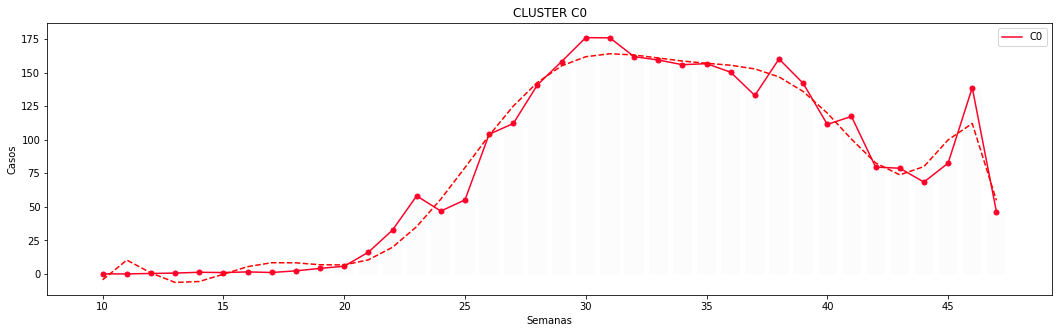

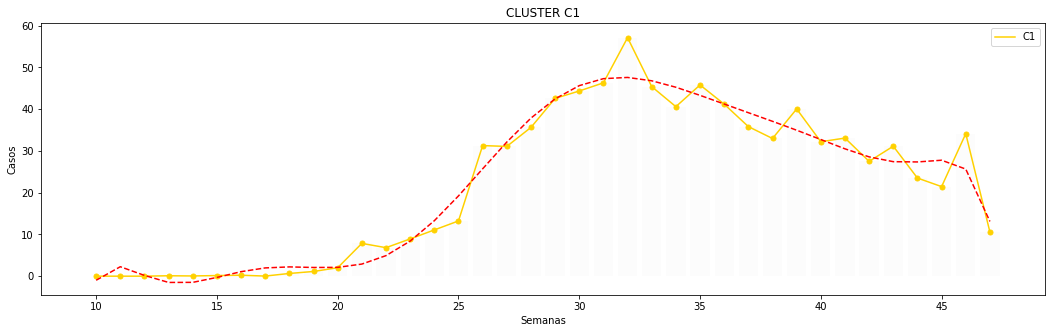

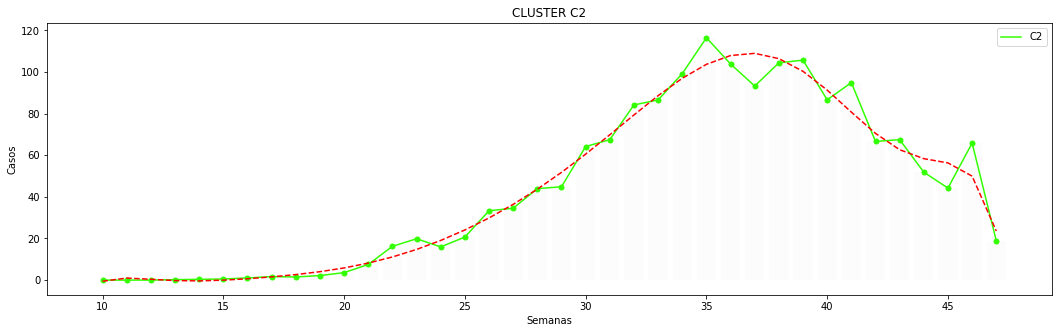

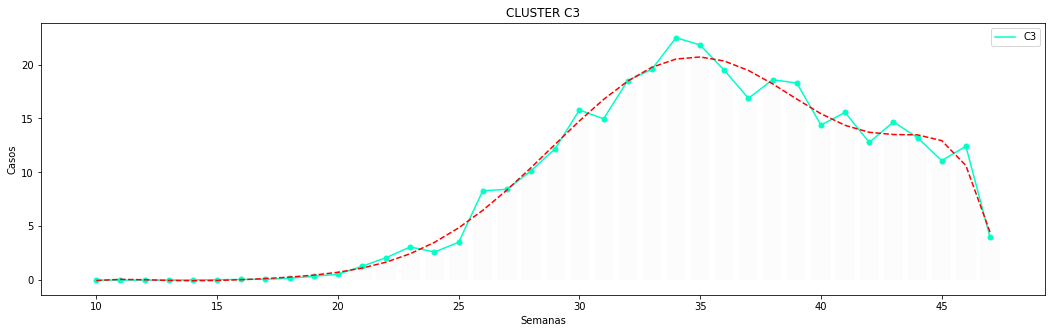

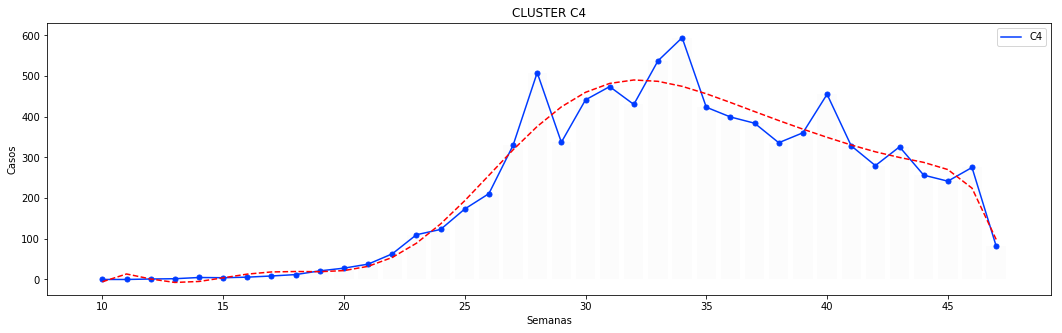

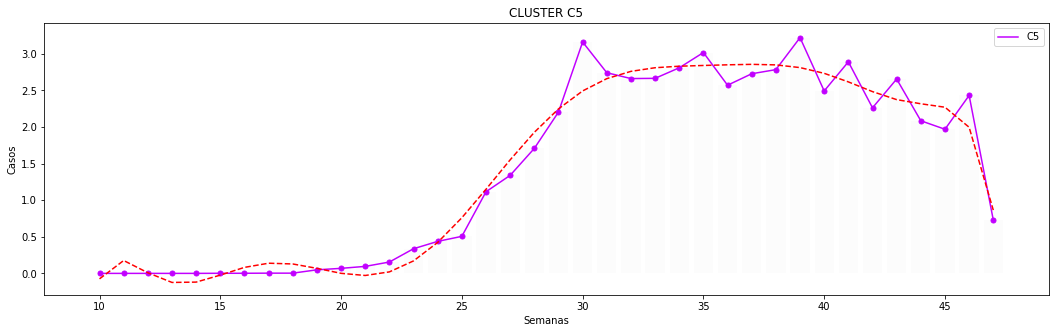

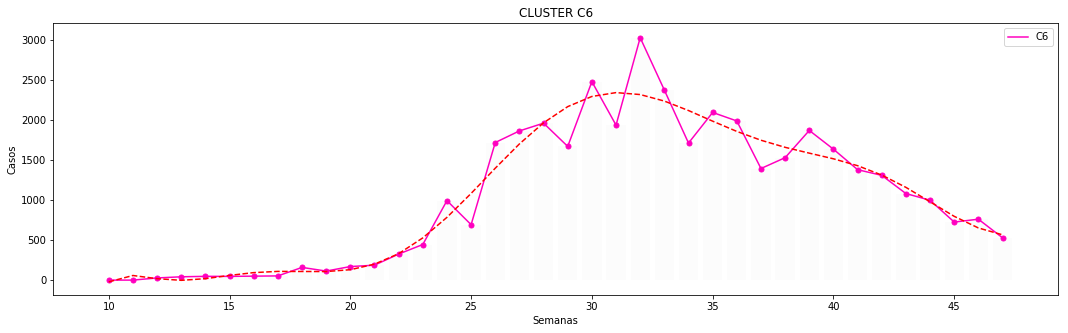

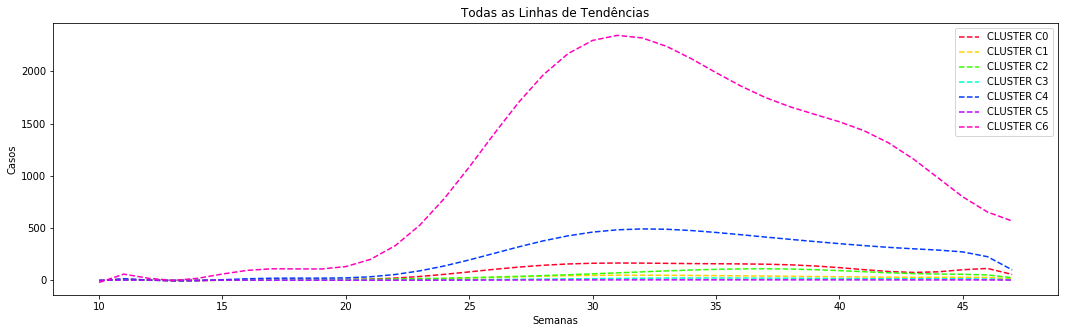

In [49]:
#SÓ CLUSTERS
from scipy.ndimage.filters import gaussian_filter1d

Y_sem = []
for y in range(0,len(X_semanal)):
    Y_sem.append(list(arr_sem))

clst_sem_labels = np.sort(pd.unique(kmeans.labels_))

for p in range(0,len(kmeans.cluster_centers_)):
    
    f, ax = plt.subplots(figsize=(18,5))
        
    viridis = plt.cm.get_cmap('gist_rainbow', 12)
    
    #xsmoothed = gaussian_filter1d(kmeans.cluster_centers_[p], sigma=0.5)
    xsmoothed = kmeans.cluster_centers_[p]
    
    plt.plot(Y_sem[p], xsmoothed, color= viridis(p+p), label='C' + str(clst_sem_labels[p]))
    plt.bar(Y_sem[p], xsmoothed, color='#FCFCFC', width=0.8, zorder=0)
    plt.scatter(Y_sem[p], kmeans.cluster_centers_[p], color= viridis(p+p), s=25)
    plt.title('CLUSTER C' + str(clst_sem_labels[p]))
    plt.xlabel('Semanas')
    plt.ylabel('Casos')
    #plt.ylim( min([sem for sem in kmeans.cluster_centers_[p]]), max([sem for sem in kmeans.cluster_centers_[p]]) * 1.1 )
    #plt.ylim(bottom=0)
    plt.legend()
    
     #Linha de Tendencia
    z = np.polyfit(Y_sem[p], kmeans.cluster_centers_[p], 10)
    pf = np.poly1d(z)
    plt.plot(Y_sem[p],pf(Y_sem[p]),"r--")

    
#Todas as Linhas de Tendencia
f, ax = plt.subplots(figsize=(18,5))
for p in range(0,len(kmeans.cluster_centers_)):
    viridis = plt.cm.get_cmap('gist_rainbow',12)
    z = np.polyfit(Y_sem[p], kmeans.cluster_centers_[p], 10)
    pf = np.poly1d(z)
    plt.plot(Y_sem[p],pf(Y_sem[p]), 'r--', color= viridis(p+p), label='CLUSTER C' + str(clst_sem_labels[p]))
    #plt.scatter(Y_sem[p], kmeans.cluster_centers_[kmeans.labels_[p]], color= viridis(p+5), s=25)
    plt.xlabel('Semanas')
    plt.ylabel('Casos')
    plt.title('Todas as Linhas de Tendências')
    plt.legend()

plt.show()

In [46]:
for k,v in sorted(clst_sem_cid.items()):
    print(k, ", ".join(sorted(v)), len(v))

0 ARCOS, CORONEL FABRICIANO, CURVELO, ESMERALDAS, EXTREMA, FERROS, IPUIUNA, MONTES CLAROS, NOVA LIMA, OURO FINO, OUTROS ESTADO/PAIS, PARAISOPOLIS, PIUMHI, RIBEIRAO DAS NEVES, SABARA, SANTA LUZIA, SANTO ANTONIO DO MONTE, SETE LAGOAS 18
1 ALEM PARAIBA, ALMENARA, ALVINOPOLIS, BAEPENDI, BOTELHOS, CAMBUQUIRA, CAMPOS ALTOS, CARBONITA, CARLOS CHAGAS, CATAGUASES, CATUJI, COROMANDEL, ESPERA FELIZ, ESPINOSA, GOVERNADOR VALADARES, GUAPE, GUIMARANIA, IRAI DE MINAS, ITAMBACURI, JAMPRUCA, LAGOA DA PRATA, LAGOA SANTA, MANGA, MARIA DA FE, MARIO CAMPOS, MINAS NOVAS, NINHEIRA, NOVA BELEM, PARACATU, PERDIZES, PIRAUBA, POUSO ALEGRE, RESENDE COSTA, SAO FRANCISCO, SAO SEBASTIAO DO OESTE, SENHORA DO PORTO, TEOFILO OTONI, TIMOTEO, VARGINHA, VESPASIANO 40
2 CAPINOPOLIS, CARMO DA CACHOEIRA, CLAUDIO, DIVINESIA, DIVINOPOLIS, GOIANA, ITAGUARA, ITAJUBA, ITAPECERICA, JANAUBA, JOAO MONLEVADE, MANHUACU, MARIANA, PATROCINIO, POCOS DE CALDAS, SANTA MARIA DE ITABIRA, SAO BRAS DO SUACUI, SAO TOMAS DE AQUINO, SARZEDO, SENA

In [1137]:
df_to_export = {}
for k,v in sorted(clst_sem_cid.items()):
    for c in v:
        df_to_export[c] = k

data = {'MUNICIPIO': list(df_to_export.values()), 'CLUSTER': list(df_to_export.keys())}
df_to_export = pd.DataFrame(data)
df_to_export
#df_to_export.to_csv(index=False, path_or_buf='municipio_clusters.csv')

,MUNICIPIO,CLUSTER
0,0,CORONEL FABRICIANO
1,0,NOVA LIMA
2,0,SETE LAGOAS
3,0,OUTROS ESTADO/PAIS
4,0,SABARA
5,0,SANTA LUZIA
6,0,ARCOS
7,0,EXTREMA
8,0,PARAISOPOLIS
9,0,SANTO ANTONIO DO MONTE


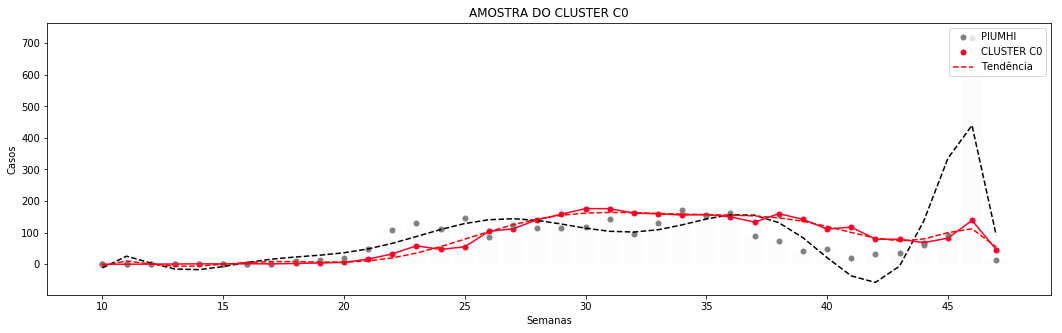

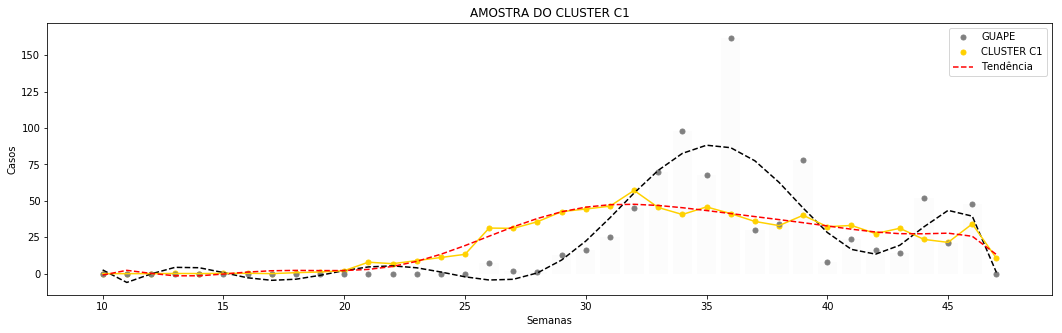

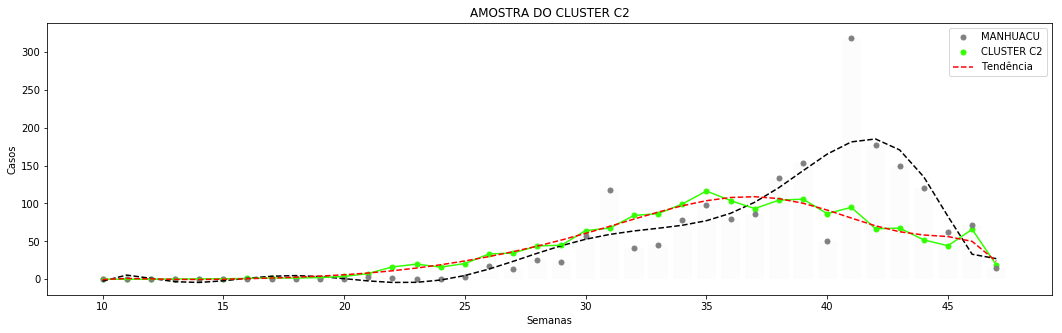

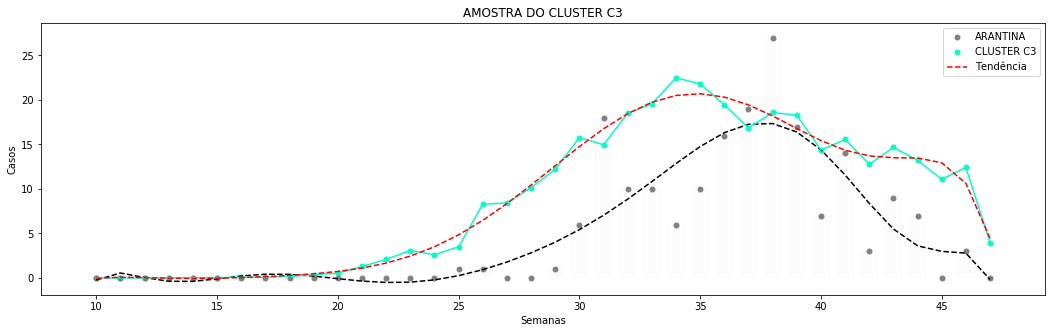

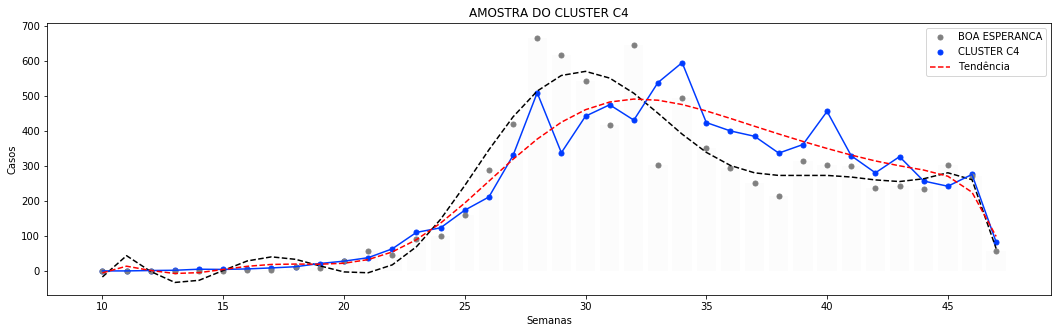

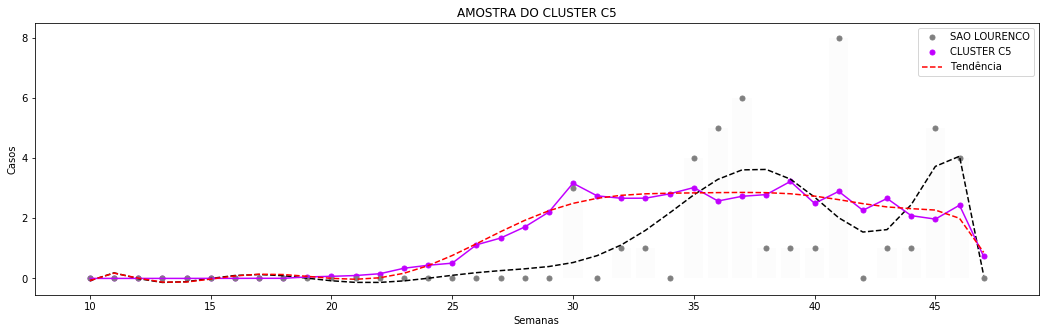

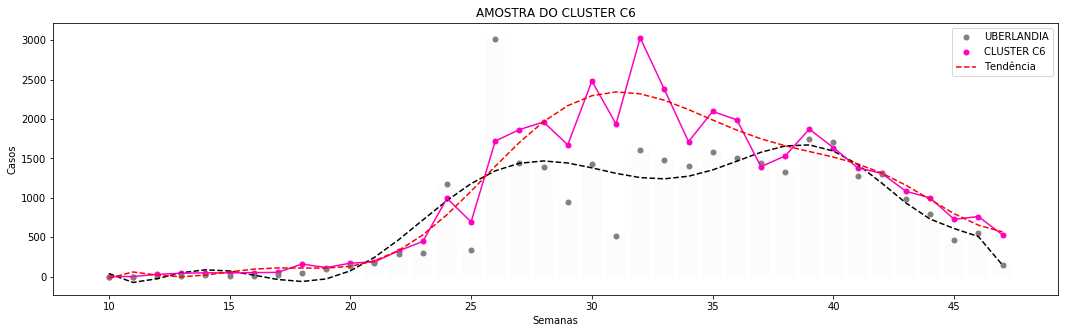

In [50]:
# PLOTANDO 1 AMOSTRA DE CADA CLUSTER

#Clusters e Cidades
#for idx, vls in sorted(clst_sem_cid.items()):
#    print(idx, vls)

for idx, vls in sorted(clst_sem_cid.items()):

    str_cid = vls[random.randint(0, len(vls)-1)]
    #str_cid = vls[0]                                 
    c_index = cidades.index(str_cid)
    
    f, ax = plt.subplots(figsize=(18,5))

    for p in range(0,len(X_semanal)):

        if (c_index == p):
            xsmoothed = X_semanal[p]
            plt.bar(Y_sem[p], xsmoothed, color='#FCFCFC', width=0.8, zorder=0)
            plt.scatter(Y_sem[p], X_semanal[p], s=25, label=cidades[p], zorder=2, color='gray')   
            
            #Linha de Tendencia
            z = np.polyfit(Y_sem[p], X_semanal[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y_sem[p],pf(Y_sem[p]),"--k")

    for p in range(0,len(kmeans.cluster_centers_)):
        if (clst_sem_reg[c_index] == p):
            plt.scatter(Y_sem[p], kmeans.cluster_centers_[p], s=25, label='CLUSTER C' + str(kmeans.labels_[c_index]), color= viridis(p+p), zorder=1)
            xsmoothed = kmeans.cluster_centers_[p]
            plt.plot(Y_sem[p], xsmoothed, color= viridis(p+p))
            
            #Linha de Tendencia
            z = np.polyfit(Y_sem[p], kmeans.cluster_centers_[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y_sem[p],pf(Y_sem[p]),"r--", label='Tendência', zorder=10)

    plt.title('AMOSTRA DO CLUSTER C' + str(str(kmeans.labels_[c_index])))
    plt.xlabel('Semanas')
    plt.ylabel('Casos')
    #plt.ylim([0, 2000])
    #plt.ylim([0, max([m.max() for m in X[c_index]]) * 1.1])
    #plt.ylim(bottom=0)
    #plt.ylim(top=20)
    #plt.legend()
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[0]]
    labels = [labels[1], labels[2], labels[0]]
    ax.legend(handles, labels, loc=1)
    plt.show()

2 Amostras


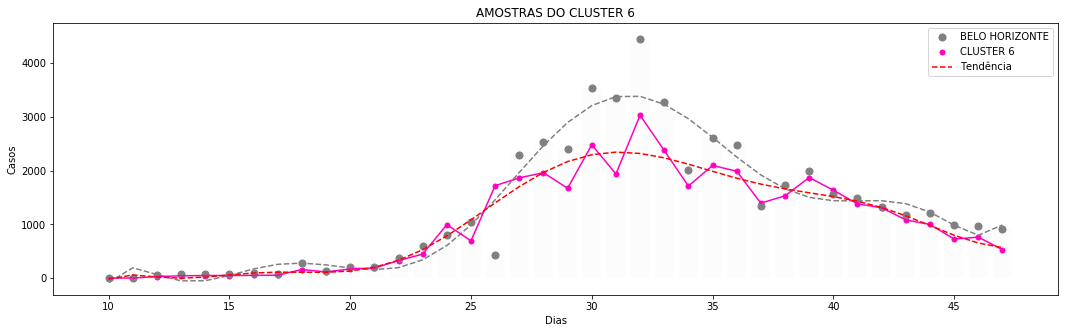

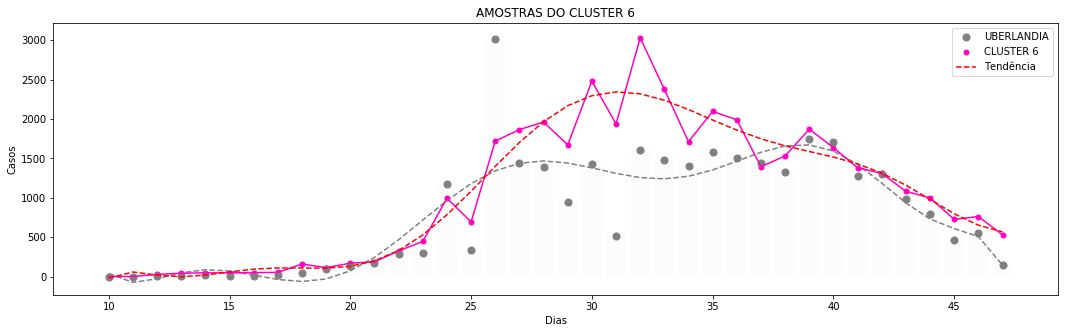

In [51]:
# PLOTANDO TODAS AS AMOSTRAS DE UM CLUSTER

cluster = 6
num_amostras = 20
print(str(len(clst_sem_cid[cluster])) + ' Amostras')
it = 0

for str_sem_cid in clst_sem_cid[cluster]:
    
    it = it + 1
    if (it > num_amostras):
        break
        
    c_index = cidades.index(str_sem_cid)
    #print(c_index, str_cid)
    
    f, ax = plt.subplots(figsize=(18,5))

    #AMOSTRA
    for p in range(0,len(X_semanal)):
        if (c_index == p):
            xsmoothed = X_semanal[p]
            plt.bar(Y_sem[p], xsmoothed, color='#FCFCFC', width=0.8, zorder=0)
            plt.scatter(Y_sem[p], X_semanal[p], s=50, label=cidades[p], zorder=2, color='gray')   
            
            #Linha de Tendencia
            z = np.polyfit(Y_sem[p], X_semanal[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y_sem[p],pf(Y_sem[p]),"--", color='gray')

    #CLUSTER
    for p in range(0,len(kmeans.cluster_centers_)):
        if (clst_sem_reg[c_index] == p):
            plt.scatter(Y_sem[p], kmeans.cluster_centers_[p], s=25, label='CLUSTER ' + str(kmeans.labels_[c_index]), color=viridis(p+p), zorder=1)
            xsmoothed = kmeans.cluster_centers_[p]
            plt.plot(Y_sem[p], xsmoothed, color=viridis(p+p))
    
            #Linha de Tendencia
            z = np.polyfit(Y_sem[p], kmeans.cluster_centers_[p], 10)
            pf = np.poly1d(z)
            plt.plot(Y_sem[p],pf(Y_sem[p]),"r--", label='Tendência', zorder=10)
            
    plt.title('AMOSTRAS DO CLUSTER ' + str(kmeans.labels_[c_index]))
    plt.xlabel('Dias')
    plt.ylabel('Casos')
    #plt.ylim(-10, 500)
    #plt.ylim([0, max([m for m in X_semanal[p]]) * 1.5])
    #plt.ylim(bottom=0)
    #plt.legend()
    
    handles,labels = ax.get_legend_handles_labels()
    handles = [handles[1], handles[2], handles[0]]
    labels = [labels[1], labels[2], labels[0]]

    ax.legend(handles, labels, loc=1)
    plt.show()

## Davies Bouldin

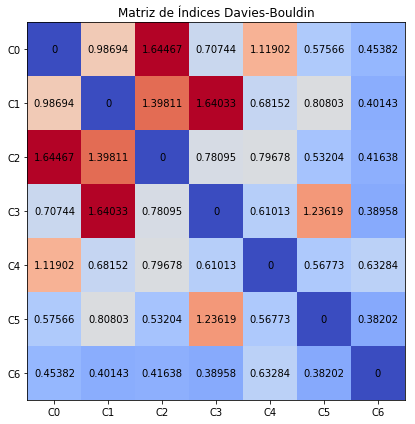

0.09040571428571428

In [221]:
from scipy.spatial.distance import euclidean

def DaviesBouldin(X, labels):
    np.set_printoptions(precision=2)
    n_cluster = len(np.bincount(labels))
    cluster_k = [X[labels == k] for k in range(n_cluster)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    variances = [np.mean([euclidean(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    #print(variances)
    db = []
    arr = []
    for i in range(n_cluster):
        db = []
        for j in range(n_cluster):
            if j != i:
                v = round((variances[i] + variances[j]) / euclidean(centroids[i], centroids[j]),5)
                #print("C" + str(i) + ' x C' + str(j) + ' = ' + str(v))
                db.append(v)
            else:
                v = 0
                db.append(v)
        arr.append(db)
        
    #print(np.array(arr))
    cols = ["C0","C1","C2","C3","C4","C5","C6"]
   
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(arr, cmap='coolwarm')
    
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(cols)

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            text = ax.text(j, i, arr[i][j],ha="center", va="center")

    ax.set_title("Matriz de Índices Davies-Bouldin")
    fig.tight_layout()
    plt.show()
    
    return(np.max(db) / n_cluster)

DaviesBouldin(X_semanal, np.array(kmeans.labels_))

In [122]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(X_semanal, np.array(kmeans.labels_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


1.36543555603292

In [77]:
kmeans.inertia_

31831160.192432635

# Análise de Correlações

- Analisar as propriedades de cada municipio de um determinado cluster
- Propriedades: Area Territorial, População, Receita, Despesa, Indice de Contaminação)

In [48]:
#LEITURA DO ARQUIVO CSV SISTEMAS

file = 'xlsx_sistemas_18112020.csv'
df_sis = pd.read_csv(file,delimiter=';',encoding='iso-8859-1',dtype='unicode')
print(len(df_sis))

205063


In [49]:
#LEITURA DO ARQUIVO CSV - DADOS DEMOGRAFICOS

file = 'dados_demograficos_municipios_mg.csv'
with open(file, 'r', encoding='cp1251') as f:
    content = re.sub(re.compile('<.*?>'), '', html.unescape(f.read()))
df_dm = pd.read_csv(StringIO(content), sep=',')
len(df_dm)

853

In [61]:
df_dm.columns

Index(['MUNICIPIO', 'CODIGO_IBGE', 'GENTILICO', 'PREFEITO', 'AREA_TERRITORIAL',
       'POPULACAO_ESTIMADA', 'DENSIDADE_DEMOGRAFICA', 'ESCOLARIDADE', 'IDH',
       'MORTALIDADE_INFANTL', 'RECEITAS_REALIZADAS', 'DESPESAS_EMPENHADAS',
       'PIB_PERCAPITA', 'CODIGO_IBGE2', 'CASOS', 'OBITOS', 'CLUSTER'],
      dtype='object')

In [50]:
#ADICIONANDO NUMERO CASOS E OBITOS

tabref = {}
tabref = pd.DataFrame(data=df_dm)

obitos = df_sis[df_sis.EVOLUCAO.eq('OBITO')]

qnt_cf = dict(df_sis['CODIGO'].value_counts())
qnt_ob = dict(obitos['CODIGO'].value_counts())

c = {}
for k,v in qnt_cf.items():
    k2 = int(k)
    c[k2] = v

o = {}
for k,v in qnt_ob.items():
    k2 = int(k)
    o[k2] = v

x = {}
for k,v in enumerate(tabref['CODIGO_IBGE']):
    v2 = int(str(v)[:6])
    x[v] = v2

tabref['CODIGO_IBGE2'] = tabref['CODIGO_IBGE'].map(x)
tabref['CASOS'] = tabref['CODIGO_IBGE2'].map(c,na_action=None)
tabref['OBITOS'] = tabref['CODIGO_IBGE2'].map(o,na_action=None)


#tabref = tabref.iloc[:,[1,4,5,6,7,8,9,10,11,12,14,15]]
tabref.head()

,MUNICIPIO,CODIGO_IBGE,GENTILICO,PREFEITO,AREA_TERRITORIAL,POPULACAO_ESTIMADA,DENSIDADE_DEMOGRAFICA,ESCOLARIDADE,IDH,MORTALIDADE_INFANTL,RECEITAS_REALIZADAS,DESPESAS_EMPENHADAS,PIB_PERCAPITA,CODIGO_IBGE2,CASOS,OBITOS
0,Abadia dos Dourados,3100104,abadiense,WANDERLEI LEMES SANTOS,881.064,7006,7.61,98.3,0.689,16.95,21894.89576,18793.52389,21953.45,310010,19.0,1.0
1,Abaeté,3100203,abaetense,ARMANDO GRECO FILHO,1817.067,23250,12.49,99.8,0.698,12.30,45220.32463,40774.21946,18044.21,310020,80.0,3.0
2,Abre Campo,3100302,abre-campense,MÁRCIO MOREIRA VICTOR,470.551,13444,28.29,97.4,0.654,27.03,32100.12090,29577.56666,13453.99,310030,92.0,1.0
3,Acaiaca,3100401,acaiaquense,LUIZ CARLOS FAUSTINO,101.886,3994,38.47,96.0,0.630,42.55,14072.55633,12445.28291,9535.73,310040,13.0,2.0
4,Açucena,3100500,açucenense,DARCIRA DE SOUZA PEREIRA,815.422,9368,12.60,96.7,0.610,26.09,19477.67359,19513.35699,9702.71,310050,102.0,4.0


In [51]:
#ADICIONANDO NUMERO DO CLUSTER

# Obtendo Codigo IBGE
clst_sem_ibge = {}
for n_cls, cid in clst_sem_cid.items():
    cid_to_ibge = []
    for c in cid:
        cod_ibge = df_conf[df_conf.MUNICIPIO.eq(c)]['COD_IBGE'].unique().astype(int)[0]
        cid_to_ibge.append(cod_ibge)
        clst_sem_ibge[cod_ibge] = n_cls

tabref['CLUSTER'] = tabref['CODIGO_IBGE2'].map(clst_sem_ibge)

#len(tabref[tabref.CLUSTER.gt(-1)])
tabref[tabref.CLUSTER.gt(-1)].head()

    

,MUNICIPIO,CODIGO_IBGE,GENTILICO,PREFEITO,AREA_TERRITORIAL,POPULACAO_ESTIMADA,DENSIDADE_DEMOGRAFICA,ESCOLARIDADE,IDH,MORTALIDADE_INFANTL,RECEITAS_REALIZADAS,DESPESAS_EMPENHADAS,PIB_PERCAPITA,CODIGO_IBGE2,CASOS,OBITOS,CLUSTER
0,Abadia dos Dourados,3100104,abadiense,WANDERLEI LEMES SANTOS,881.064,7006,7.61,98.3,0.689,16.95,21894.89576,18793.52389,21953.45,310010,19.0,1.0,5.0
1,Abaeté,3100203,abaetense,ARMANDO GRECO FILHO,1817.067,23250,12.49,99.8,0.698,12.30,45220.32463,40774.21946,18044.21,310020,80.0,3.0,3.0
2,Abre Campo,3100302,abre-campense,MÁRCIO MOREIRA VICTOR,470.551,13444,28.29,97.4,0.654,27.03,32100.12090,29577.56666,13453.99,310030,92.0,1.0,5.0
3,Acaiaca,3100401,acaiaquense,LUIZ CARLOS FAUSTINO,101.886,3994,38.47,96.0,0.630,42.55,14072.55633,12445.28291,9535.73,310040,13.0,2.0,5.0
4,Açucena,3100500,açucenense,DARCIRA DE SOUZA PEREIRA,815.422,9368,12.60,96.7,0.610,26.09,19477.67359,19513.35699,9702.71,310050,102.0,4.0,3.0


In [1178]:
print(len(dict_dados))

7


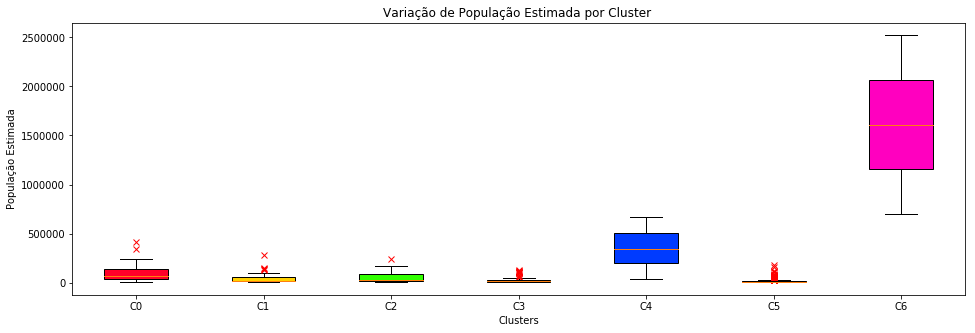

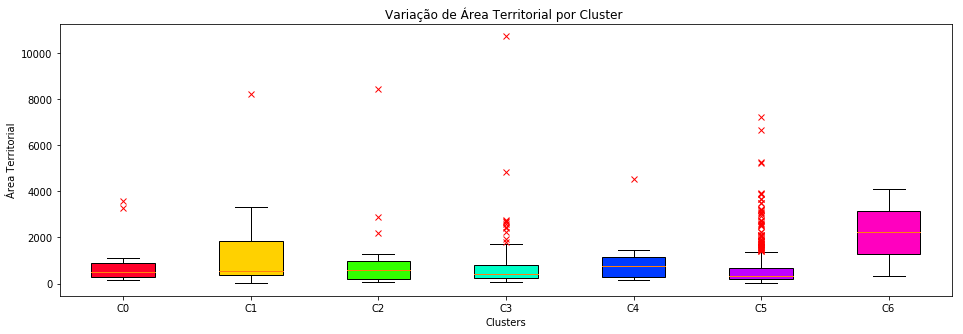

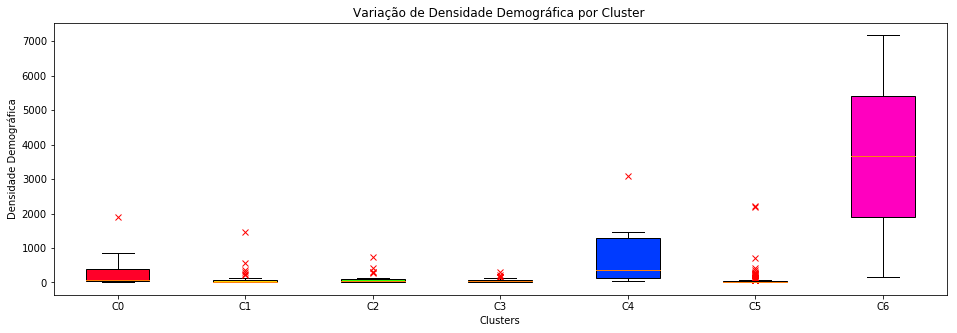

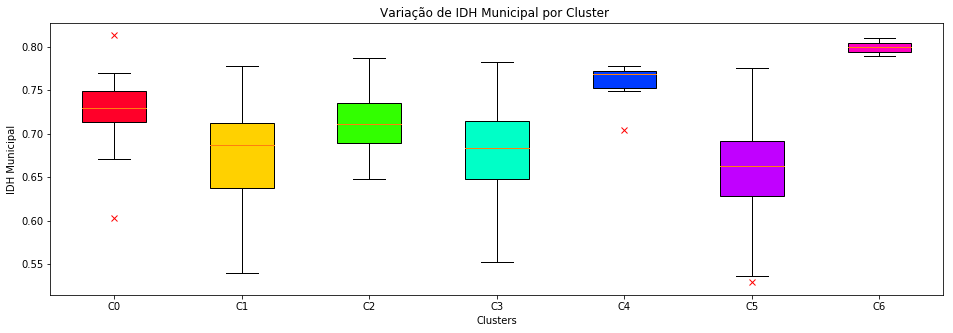

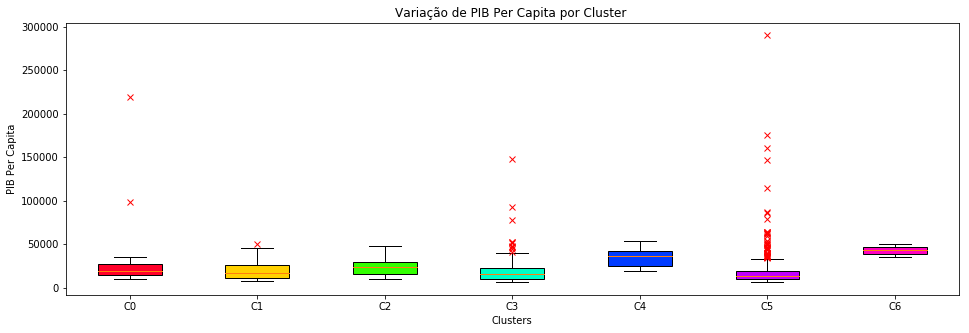

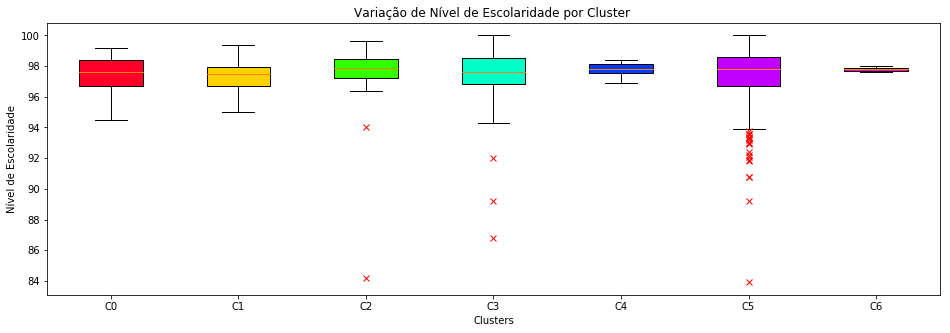

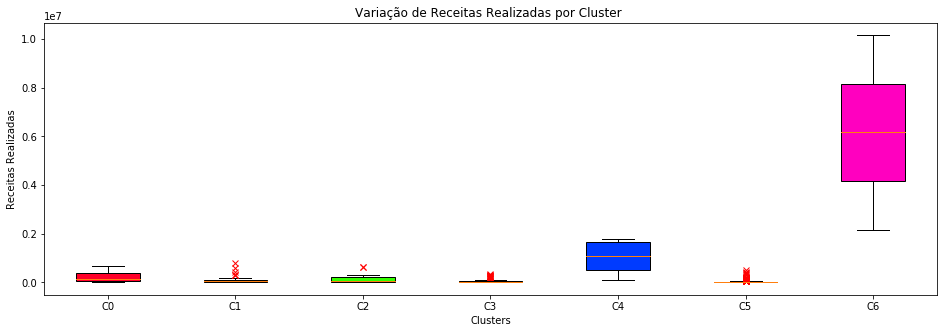

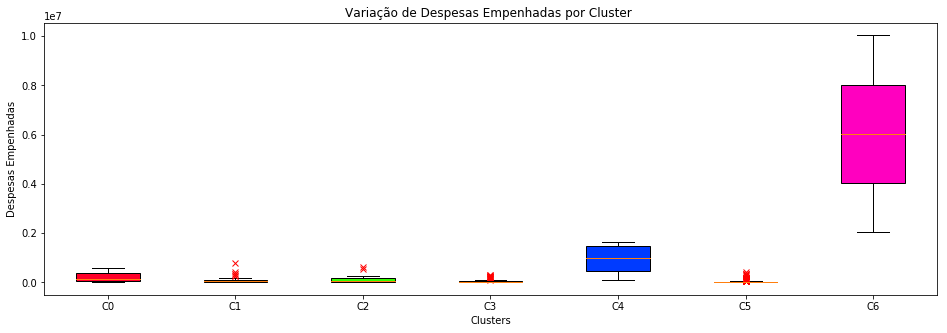

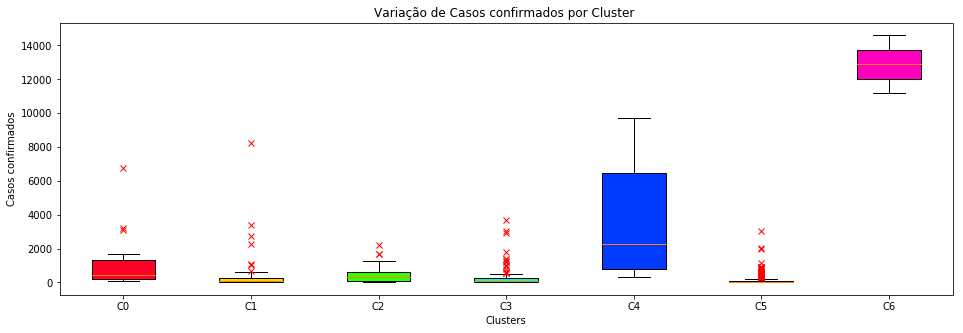

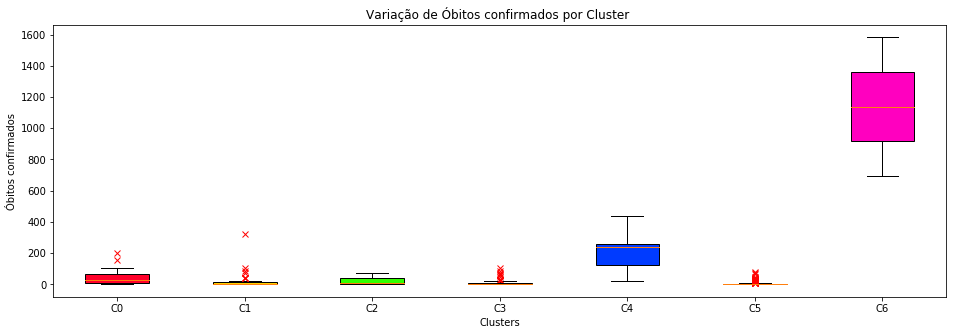

In [54]:
# BOXPLOT DE VARIAVEIS POR CLUSTER

dict_cls_pop = {}
dict_cls_area = {}
dict_cls_dens = {}
dict_cls_idhm = {}
dict_cls_pib = {}
dict_cls_esco = {}
dict_cls_rece = {}
dict_cls_desp = {}
dict_cls_casos = {}
dict_cls_obitos = {}
#print(clst_sem_ibge)

for ibge, n_cls in sorted(clst_sem_ibge.items()):
    dict_cls_pop[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['POPULACAO_ESTIMADA'].tolist()
    dict_cls_area[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['AREA_TERRITORIAL'].tolist()
    dict_cls_dens[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['DENSIDADE_DEMOGRAFICA'].tolist()
    dict_cls_idhm[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['IDH'].tolist()
    dict_cls_pib[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['PIB_PERCAPITA'].tolist()
    dict_cls_esco[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['ESCOLARIDADE'].tolist()
    dict_cls_rece[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['RECEITAS_REALIZADAS'].tolist()
    dict_cls_desp[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['DESPESAS_EMPENHADAS'].tolist()
    dict_cls_casos[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['CASOS'].fillna(0).tolist()
    dict_cls_obitos[n_cls] = tabref[tabref.CLUSTER.eq(n_cls)]['OBITOS'].fillna(0).tolist()

# Join all Dicts
dict_vars = {}
dict_vars['POPULACAO'] = {'title':'População Estimada', 'dados':dict_cls_pop}
dict_vars['AREA'] = {'title':'Área Territorial', 'dados':dict_cls_area}
dict_vars['DENSIDADE'] = {'title':'Densidade Demográfica', 'dados':dict_cls_dens}
dict_vars['IDHM'] = {'title':'IDH Municipal', 'dados':dict_cls_idhm}
dict_vars['PIB'] = {'title':'PIB Per Capita', 'dados':dict_cls_pib}
dict_vars['ESCOLARIDADE'] = {'title':'Nível de Escolaridade', 'dados':dict_cls_esco}
dict_vars['RECEITAS'] = {'title':'Receitas Realizadas', 'dados':dict_cls_rece}
dict_vars['DESPESAS'] = {'title':'Despesas Empenhadas', 'dados':dict_cls_desp}
dict_vars['CASOS'] = {'title':'Casos confirmados', 'dados':dict_cls_casos}
dict_vars['OBITOS'] = {'title':'Óbitos confirmados', 'dados':dict_cls_obitos}
    
# Municipios por Cluster
#for k,v in sorted(clst_sem_cid.items()):
#    print('C'+str(k),v)

# BoxPlot Clusters por Tema
for d_nome, d_dados in dict_vars.items():
    dict_dados = {}
    dict_dados = d_dados['dados']
    dict_ord = dict(sorted(dict_dados.items()))
    f, ax = plt.subplots(figsize=(16,5))
    bx = plt.boxplot(dict_ord.values(), patch_artist=True, sym='rx', showfliers=True)
    colors = [viridis(i+i) for i in range(0, len(dict_dados))]
    for patch, color in zip(bx['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.xticks(np.arange(1,len(dict_ord)+1), ['C'+str(k) for k in dict_ord.keys()])
    plt.xlabel("Clusters")
    plt.ylabel(d_dados['title'])
    plt.title('Variação de ' + d_dados['title'] + ' por Cluster ')
    plt.show()

In [1143]:
tabref[tabref.CLUSTER.eq(4)]

,MUNICIPIO,CODIGO_IBGE,GENTILICO,PREFEITO,AREA_TERRITORIAL,POPULACAO_ESTIMADA,DENSIDADE_DEMOGRAFICA,ESCOLARIDADE,IDH,MORTALIDADE_INFANTL,RECEITAS_REALIZADAS,DESPESAS_EMPENHADAS,PIB_PERCAPITA,CODIGO_IBGE2,CASOS,OBITOS,CLUSTER
60,Barbacena,3105608,barbacenense,LUIS ÁLVARO ABRANTES CAMPOS,759.186,138204,166.34,98.4,0.769,10.22,3.440248e+05,3.209918e+05,19631.86,310560,538.0,22.0,4.0
71,Betim,3106705,betinense,VITTORIO MEDIOLI,343.884,444784,1102.80,98.0,0.749,8.45,1.775733e+06,1.363402e+06,54052.13,310670,4936.0,239.0,4.0
75,Boa Esperança,3107109,esperancense,HIDERALDO HENRIQUE SILVA,860.669,40219,44.75,96.9,0.704,14.98,1.089632e+05,1.007901e+05,20555.41,310710,325.0,20.0,4.0
204,Contagem,3118601,contagense,ALEXIS JOSÉ FERREIRA DE FREITAS,194.746,668949,3090.33,97.4,0.756,9.99,1.712722e+06,1.632665e+06,44015.99,311860,9698.0,438.0,4.0
356,Ipatinga,3131307,ipatinguense,NARDYELLO ROCHA DE OLIVEIRA,164.884,265409,1452.34,97.8,0.771,8.89,6.824658e+05,6.337344e+05,36993.39,313130,8016.0,237.0,4.0
419,Juiz de Fora,3136702,juiz-forano,ANTÔNIO CARLOS GUEDES ALMAS,1435.749,573285,359.59,98.3,0.778,10.32,1.578268e+06,1.571854e+06,28355.07,313670,2259.0,280.0,4.0
822,Uberaba,3170107,uberabense,PAULO PIAU NOGUEIRA,4523.957,337092,65.43,97.7,0.772,9.87,1.086839e+06,9.770983e+05,40066.32,317010,1029.0,223.0,4.0


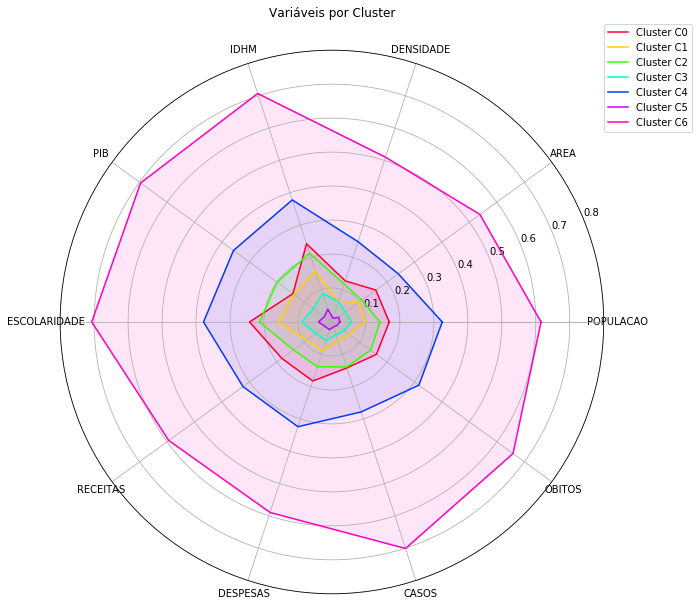

In [55]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer()

tema_ = list(dict_vars.keys())

# Initialise the spider plot by setting figure size and polar projection
plt.figure(figsize=(10, 10))
plt.subplot(polar=True)

# Setting Theta
theta = np.linspace(0, 2 * np.pi, len(tema_)+1)
#print(theta)

# Setting max radius score
ax=plt.gca()
ax.set_rlim(0,0.8)

# Arrange the grid into number of sales equal parts in degrees
#lines, labels = plt.thetagrids(range(0, 360, int(360/(len(tema_)))), (tema_))
lines, labels = plt.thetagrids([int(a * 180 / np.pi) for a in theta], (tema_))

# Calculate media values array
medialist_ = []
labellist = []
for k,v in dict_vars.items():
    #print(k)
    media_ = []
    for c, d in sorted(v['dados'].items()):
        #print(c,d)
        df_vars = pd.DataFrame(d).transpose()
        norm_vars = scaler.fit_transform(df_vars)
        mean_vars = norm_vars.mean() #media
        #mean_vars = np.median(norm_vars) #mediana
        media_.append(mean_vars)
        #print('C'+str(c)+' - ', mean_vars)
        if 'Cluster C'+str(c) not in labellist: labellist.append('Cluster C'+str(c))
    #print('---')
    medialist_.append(media_)

# Adding copy first position to last
medialist_.append(medialist_[0])
medialist_ = np.array(medialist_).transpose()

# Plotting values
colors = [viridis(i+i) for i in range(0, len(labellist))]
#print(colors)
for i in range(0, len(medialist_)):
    #Plotting
    #print(i)
    plt.plot(theta, medialist_[i], color=colors[i])
    plt.fill(theta, medialist_[i], alpha=0.1, color=colors[i])

# Add legend and title for the plot
plt.legend(labels=labellist, loc=[1.0,0.85])
plt.title("Variáveis por Cluster")

# Display the plot on the screen
plt.show()

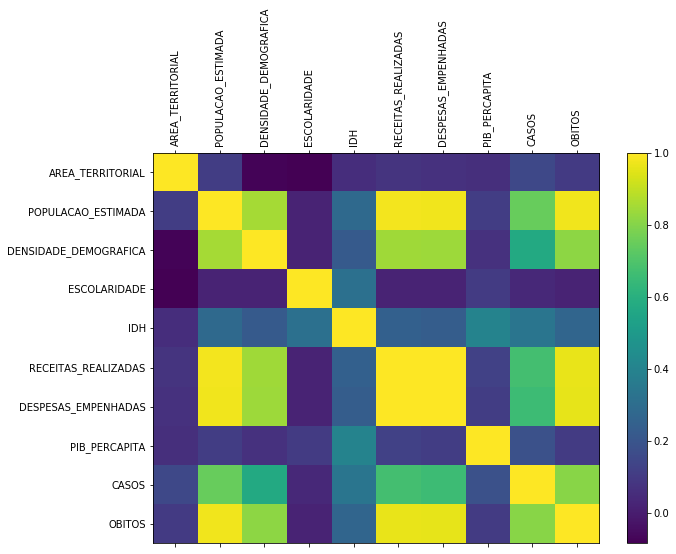

In [792]:
# CORRELAÇÕES
corr_tabref = tabref.iloc[:,[4,5,6,7,8,9,10,11,12,14,15]]
corr = corr_tabref.corr()

plt.figure(figsize=(10,7))
plt.matshow(corr,fignum=1,aspect='auto')
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [806]:
# MAPA DE CORRELAÇÕES
corr_tabref = tabref.iloc[:,[4,5,6,7,8,9,10,11,12,14,15]]
sm_cols = (['AREA','POP','DENS','ESC','IDH','REC','DESP','PIB','CASOS','OBITOS'])
corr = corr_tabref.corr()
corr.columns = sm_cols
#corr.index = sm_cols
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3).set_table_styles([dict(selector="tbody tr",props=[('height','40px')])])
#formatação
#corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(4).set_table_styles([dict(selector="thead th",props=[('transform', 'rotate(-90deg)'),('position','relative'),('top','-20px'),('text-align','left')])]).set_table_styles([dict(selector="thead",props=[('border', '0')])])

,AREA,POP,DENS,ESC,IDH,REC,DESP,PIB,CASOS,OBITOS
AREA_TERRITORIAL,1,0.114,-0.0732,-0.0854,0.057,0.078,0.0702,0.0614,0.149,0.0982
POPULACAO_ESTIMADA,0.114,1,0.854,0.021,0.285,0.981,0.977,0.11,0.749,0.976
DENSIDADE_DEMOGRAFICA,-0.0732,0.854,1,0.023,0.221,0.843,0.843,0.0713,0.575,0.813
ESCOLARIDADE,-0.0854,0.021,0.023,1,0.313,0.0233,0.0211,0.101,0.0383,0.0218
IDH,0.057,0.285,0.221,0.313,1,0.247,0.234,0.4,0.338,0.27
RECEITAS_REALIZADAS,0.078,0.981,0.843,0.0233,0.247,1,0.999,0.123,0.675,0.962
DESPESAS_EMPENHADAS,0.0702,0.977,0.843,0.0211,0.234,0.999,1,0.111,0.659,0.959
PIB_PERCAPITA,0.0614,0.11,0.0713,0.101,0.4,0.123,0.111,1,0.183,0.103
CASOS,0.149,0.749,0.575,0.0383,0.338,0.675,0.659,0.183,1,0.808
OBITOS,0.0982,0.976,0.813,0.0218,0.27,0.962,0.959,0.103,0.808,1
